# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from openai import OpenAI
import time
from ortools.sat.python import cp_model
import numpy as np
import matplotlib.patches as mpatches
from dotenv import load_dotenv
import os


load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

# Understanding and Loading the data

In [3]:
# === CONFIG ===
csv_path = "viewership_tv_aug.csv"

# === LOAD DATA ===
df = pd.read_csv(csv_path)

### Checking there types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4464 entries, 0 to 4463
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   4464 non-null   int64 
 1   Date         4464 non-null   object
 2   Time         4464 non-null   object
 3   ProgramName  4464 non-null   object
 4   Genre        4464 non-null   object
 5   Episode      3906 non-null   object
 6   TRP          4464 non-null   object
dtypes: int64(1), object(6)
memory usage: 244.2+ KB


In [5]:
# df['TRP'] = df['TRP'].astype(int)  # could not work as the original number as a comma which cannot convert it to integer immedietely 

# Remove commas and convert to integer
df['TRP'] = df['TRP'].str.replace(',', '').astype(int)

In [6]:
df.info()

df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4464 entries, 0 to 4463
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   4464 non-null   int64 
 1   Date         4464 non-null   object
 2   Time         4464 non-null   object
 3   ProgramName  4464 non-null   object
 4   Genre        4464 non-null   object
 5   Episode      3906 non-null   object
 6   TRP          4464 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 244.2+ KB


,Unnamed: 0,Date,Time,ProgramName,Genre,Episode,TRP
0,0,2025-08-01,00:00,Stranger Things,Drama,1,66957


In [7]:
df['ProgramName'].unique()

array(['Stranger Things', 'Vikings', 'Squid Game', 'House', 'The Office',
       'Bridgerton', 'Good Morning America', 'Breaking Bad',
       'The Sopranos', 'Suits', 'The News', 'The Walking Dead',
       'Football Match', 'The Big Bang Theory', 'How I Met Your Mother',
       "Grey's Anatomy", 'Peaky Blinders', 'Friends', 'Game Of Thrones',
       'Modern Family'], dtype=object)

In [8]:
df.head(4)

,Unnamed: 0,Date,Time,ProgramName,Genre,Episode,TRP
0,0,2025-08-01,00:00,Stranger Things,Drama,1,66957
1,1,2025-08-01,00:10,Stranger Things,Drama,1,12897
2,2,2025-08-01,00:20,Stranger Things,Drama,1,3150
3,3,2025-08-01,00:30,Stranger Things,Drama,1,17998


### The time is grouped every 10 minutes we need to change that to make it every 30

In [9]:
# Combine Date + Time
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Map to TV date
df['TV_Date'] = df['DateTime'].apply(lambda x: x.date() if x.hour >= 6 else (x - pd.Timedelta(days=1)).date())

# Assign day of week (0=Monday, 6=Sunday)
df['Day_of_Week'] = pd.to_datetime(df['TV_Date']).dt.dayofweek

In [10]:
# Assign slot index for 30-min slots
def get_slot_index(dt):
    minutes_since_6am = dt.hour*60 + dt.minute - 360  # 360 = 6*60
    if minutes_since_6am < 0:
        minutes_since_6am += 1440  # wrap around midnight
    return minutes_since_6am // 30

df['Slot_Index'] = df['DateTime'].apply(get_slot_index)


In [11]:
df

,Unnamed: 0,Date,Time,ProgramName,Genre,Episode,TRP,DateTime,TV_Date,Day_of_Week,Slot_Index
0,0,2025-08-01,00:00,Stranger Things,Drama,1,66957,2025-08-01 00:00:00,2025-07-31,3,36
1,1,2025-08-01,00:10,Stranger Things,Drama,1,12897,2025-08-01 00:10:00,2025-07-31,3,36
2,2,2025-08-01,00:20,Stranger Things,Drama,1,3150,2025-08-01 00:20:00,2025-07-31,3,36
3,3,2025-08-01,00:30,Stranger Things,Drama,1,17998,2025-08-01 00:30:00,2025-07-31,3,37
4,4,2025-08-01,00:40,Stranger Things,Drama,1,21798,2025-08-01 00:40:00,2025-07-31,3,37
...,...,...,...,...,...,...,...,...,...,...,...
4459,4459,2025-08-31,23:10,Suits,Drama,35,3471,2025-08-31 23:10:00,2025-08-31,6,34
4460,4460,2025-08-31,23:20,Suits,Drama,35,24106,2025-08-31 23:20:00,2025-08-31,6,34
4461,4461,2025-08-31,23:30,Suits,Drama,35,21547,2025-08-31 23:30:00,2025-08-31,6,35
4462,4462,2025-08-31,23:40,Suits,Drama,35,7418,2025-08-31 23:40:00,2025-08-31,6,35


In [12]:
# aggregate 10 min TRP into 30-min time slots
slot_trp = df.groupby(['TV_Date', 'Slot_Index', 'Genre', 'ProgramName', 'Day_of_Week']).agg({'TRP':'sum'}).reset_index()


In [13]:
slot_trp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TV_Date      1488 non-null   object
 1   Slot_Index   1488 non-null   int64 
 2   Genre        1488 non-null   object
 3   ProgramName  1488 non-null   object
 4   Day_of_Week  1488 non-null   int32 
 5   TRP          1488 non-null   int64 
dtypes: int32(1), int64(2), object(3)
memory usage: 64.1+ KB


## Visualization

In [14]:
# Mark weekend
slot_trp['Is_Weekend'] = slot_trp['Day_of_Week'].apply(lambda x: 1 if x >=5 else 0)

# Average TRP per slot
avg_trp = slot_trp.groupby(['Slot_Index', 'Is_Weekend', 'Genre']).agg({'TRP':'mean'}).reset_index()

# Average TRP by slot index  and weekday/weekend
pivot = avg_trp.pivot_table(index='Slot_Index', columns=['Is_Weekend','Genre'], values='TRP')


### Average TRP in the weekday

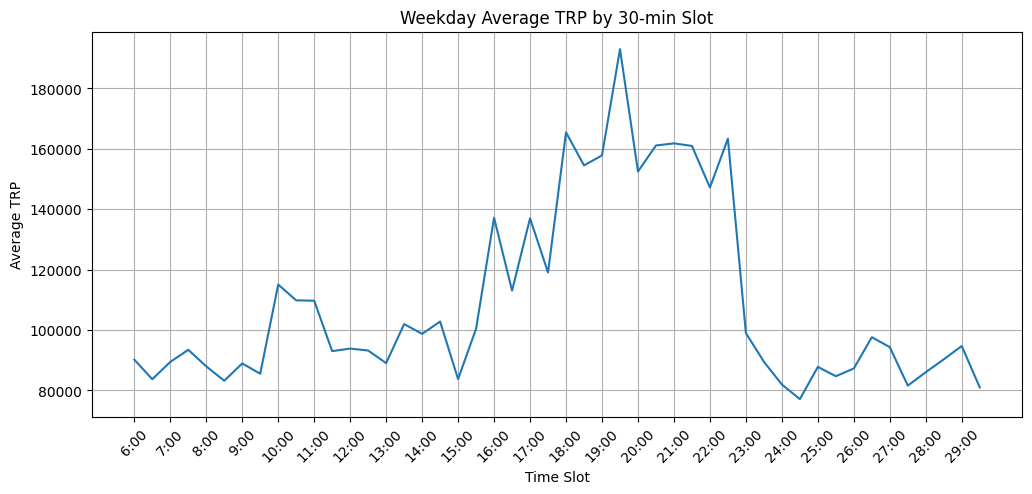

In [15]:
# Example: Average TRP for all genres, weekdays only
weekday_avg = avg_trp[avg_trp['Is_Weekend']==0].groupby('Slot_Index')['TRP'].mean()
plt.figure(figsize=(12,5))
plt.plot(range(48), weekday_avg)
plt.xticks(ticks=range(0,48,2), labels=[f"{6+i//2}:{(i%2)*30:02d}" for i in range(0,48,2)], rotation=45)
plt.xlabel("Time Slot")
plt.ylabel("Average TRP")
plt.title("Weekday Average TRP by 30-min Slot")
plt.grid(True)
plt.show()

### Average TRP in the weekend

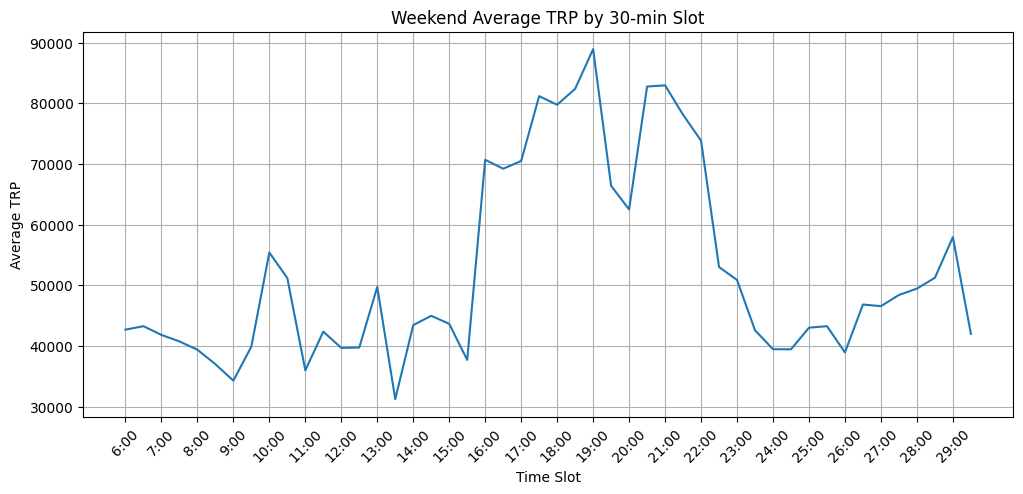

In [16]:
# Example: Average TRP for all genres, weekdays only
weekday_avg = avg_trp[avg_trp['Is_Weekend']==1].groupby('Slot_Index')['TRP'].mean()
plt.figure(figsize=(12,5))
plt.plot(range(48), weekday_avg)
plt.xticks(ticks=range(0,48,2), labels=[f"{6+i//2}:{(i%2)*30:02d}" for i in range(0,48,2)], rotation=45)
plt.xlabel("Time Slot")
plt.ylabel("Average TRP")
plt.title("Weekend Average TRP by 30-min Slot")
plt.grid(True)
plt.show()

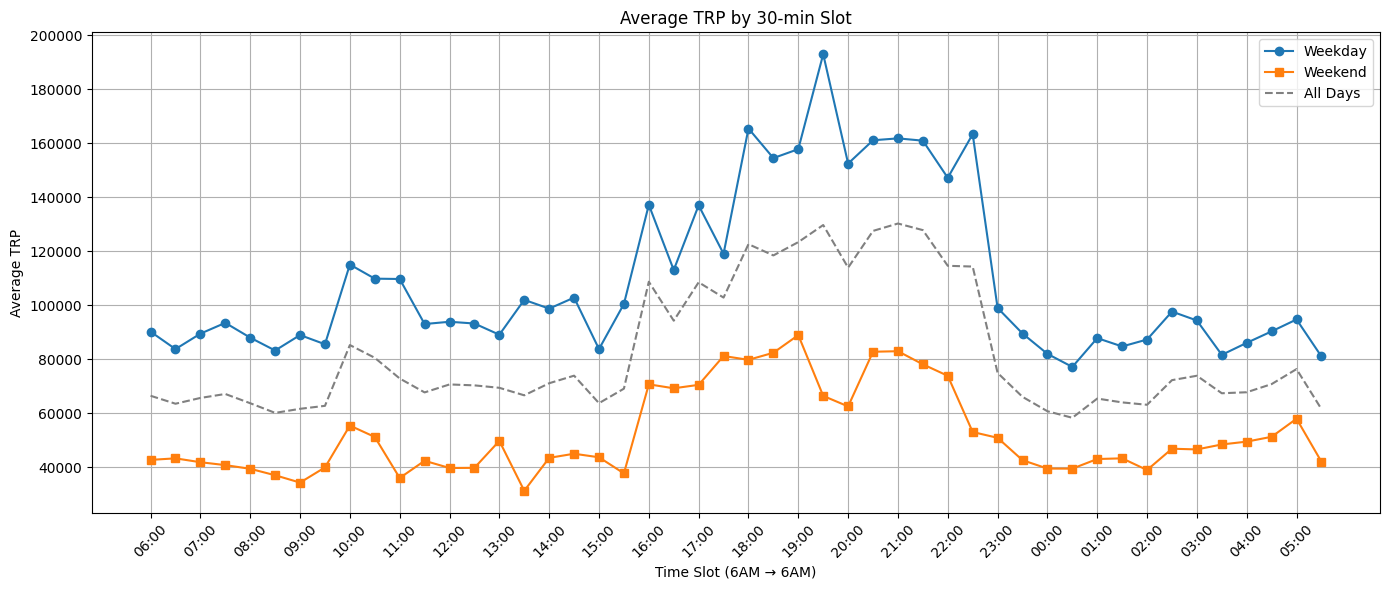

In [102]:
# Function to generate time labels for TV day 6AM-6AM
def tv_time_labels(num_slots=48, start_hour=6):
    labels = []
    for i in range(num_slots):
        total_minutes = start_hour*60 + i*30
        hour = (total_minutes // 60) % 24  # wrap around 24h
        minute = total_minutes % 60
        labels.append(f"{hour:02d}:{minute:02d}")
    return labels

TIME_LABELS = tv_time_labels()

# Average TRP calculations
weekday_avg = avg_trp[avg_trp['Is_Weekend']==0].groupby('Slot_Index')['TRP'].mean()
weekend_avg = avg_trp[avg_trp['Is_Weekend']==1].groupby('Slot_Index')['TRP'].mean()
all_avg = avg_trp.groupby('Slot_Index')['TRP'].mean()

# Plot Weekday, Weekend, All
plt.figure(figsize=(14,6))
plt.plot(range(48), weekday_avg, label="Weekday", marker='o')
plt.plot(range(48), weekend_avg, label="Weekend", marker='s')
plt.plot(range(48), all_avg, label="All Days", linestyle='--', color='gray')
plt.xticks(ticks=range(0,48,2), labels=[TIME_LABELS[i] for i in range(0,48,2)], rotation=45)
plt.xlabel("Time Slot (6AM → 6AM)")
plt.ylabel("Average TRP")
plt.title("Average TRP by 30-min Slot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Shows being shown at 19:00 during the weekend
weekend_19 = slot_trp[(slot_trp['Is_Weekend']==1) & (slot_trp['Slot_Index']==26)]

# Show ProgramName, Genre, TRP
weekend_19[['TV_Date', 'ProgramName', 'Genre', 'TRP']]


,TV_Date,ProgramName,Genre,TRP
86,2025-08-02,Peaky Blinders,Action,82124
134,2025-08-03,Game Of Thrones,Action,53790
422,2025-08-09,The Sopranos,Drama,141534
470,2025-08-10,Breaking Bad,Drama,66002
758,2025-08-16,Grey's Anatomy,Romance,115124
806,2025-08-17,Friends,Comedy,103582
1094,2025-08-23,Football Match,Sports,92579
1142,2025-08-24,Football Match,Sports,91082
1430,2025-08-30,Game Of Thrones,Action,38198
1478,2025-08-31,The Office,Comedy,48108


In [18]:
# Shows being shown at 19:00 during the weekday
weekday_19 = slot_trp[(slot_trp['Is_Weekend']==0) & (slot_trp['Slot_Index']==2)]

# Show ProgramName, Genre, TRP
weekday_19[['TV_Date', 'ProgramName', 'Genre', 'TRP']]


,TV_Date,ProgramName,Genre,TRP
14,2025-08-01,Bridgerton,Romance,111634
158,2025-08-04,House,Romance,62668
206,2025-08-05,Grey's Anatomy,Romance,75421
254,2025-08-06,Game Of Thrones,Action,62608
302,2025-08-07,Stranger Things,Drama,105513
350,2025-08-08,The Walking Dead,Drama,130374
494,2025-08-11,Suits,Drama,84549
542,2025-08-12,Bridgerton,Romance,83407
590,2025-08-13,Stranger Things,Drama,90058
638,2025-08-14,Stranger Things,Drama,112476


### TRP by Genre

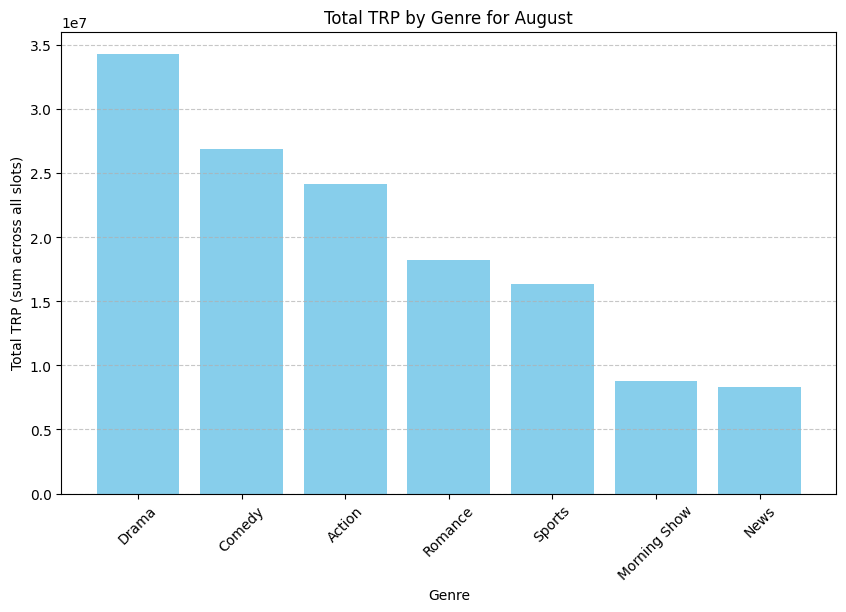

In [19]:
# === Aggregate TRP by genre ===
genre_trp = slot_trp.groupby('Genre')['TRP'].sum().sort_values(ascending=False)

# ===Plot a bar chart ===
plt.figure(figsize=(10,6))
plt.bar(genre_trp.index, genre_trp.values, color='skyblue')
plt.xlabel("Genre")
plt.ylabel("Total TRP (sum across all slots)")
plt.title("Total TRP by Genre for August")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Checking TRP by Genre during Peak times

Genre
Sports     16363785
Drama      12170436
Comedy      9793292
Action      8704126
News        8341112
Romance     7004330
Name: TRP, dtype: int64


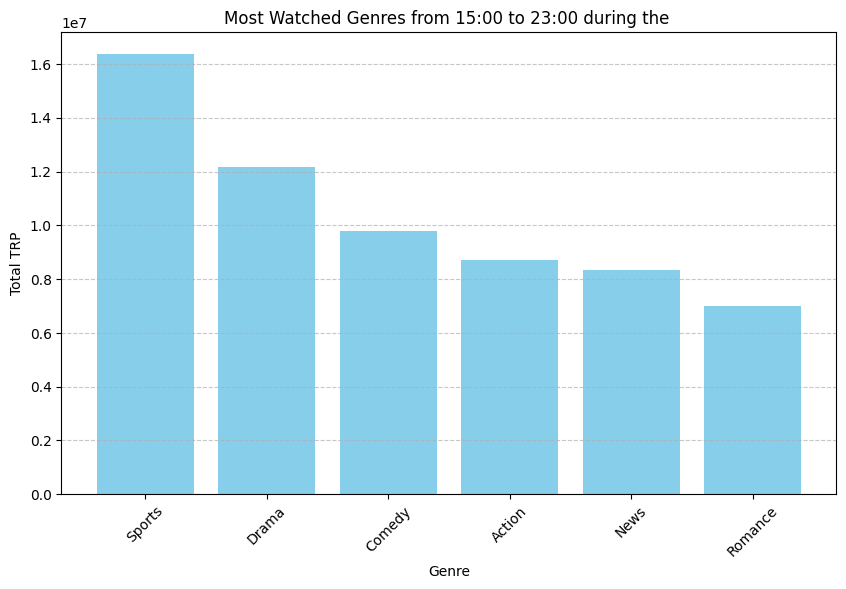

In [20]:
# Filter the relevant slots
afternoon_evening_slots = slot_trp[(slot_trp['Slot_Index'] >= 18) & (slot_trp['Slot_Index'] <= 34)]

# Aggregate TRP by Genre
genre_trp_15_23 = afternoon_evening_slots.groupby('Genre')['TRP'].sum().sort_values(ascending=False)

# Display
print(genre_trp_15_23)

# Optional: visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(genre_trp_15_23.index, genre_trp_15_23.values, color='skyblue')
plt.xlabel("Genre")
plt.ylabel("Total TRP")
plt.title("Most Watched Genres from 15:00 to 23:00 during the ")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [21]:

# Slot index range for 15:00-23:00
start_slot = 18
end_slot = 34

slots_15_23 = slot_trp[(slot_trp['Slot_Index'] >= start_slot) & (slot_trp['Slot_Index'] <= end_slot)]
genre_trp_by_daytype = slots_15_23.groupby(['Is_Weekend', 'Genre'])['TRP'].sum().unstack(fill_value=0)
genre_trp_by_daytype.rename({0:'Weekday', 1:'Weekend'}, axis=0, inplace=True)


### Visualize weekend vs weekday viewers by Genre

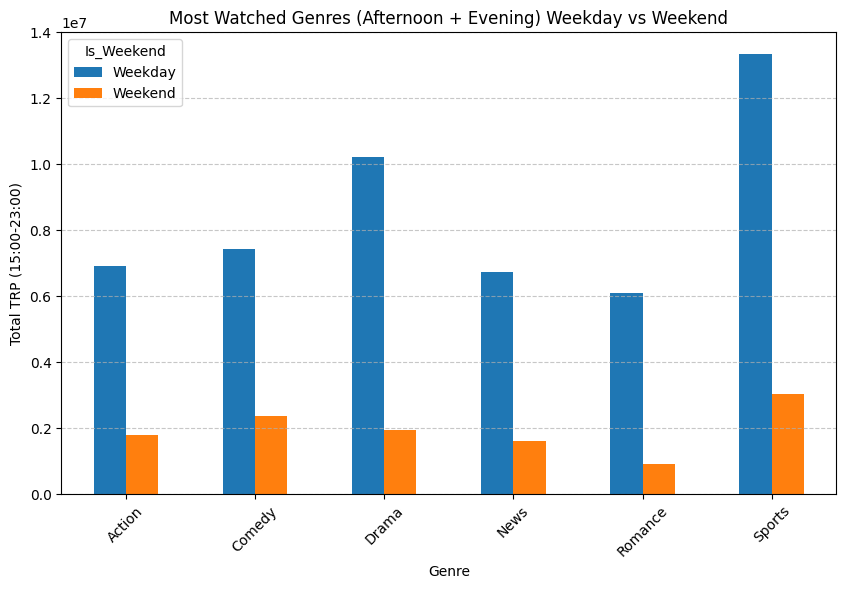

In [ ]:

genre_trp_by_daytype.T.plot(kind='bar', figsize=(10,6))
plt.xlabel("Genre")
plt.ylabel("Total TRP (15:00-23:00)")
plt.title("Most Watched Genres (Afternoon + Evening) Weekday vs Weekend")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### TRP average of Genres that we are interested in

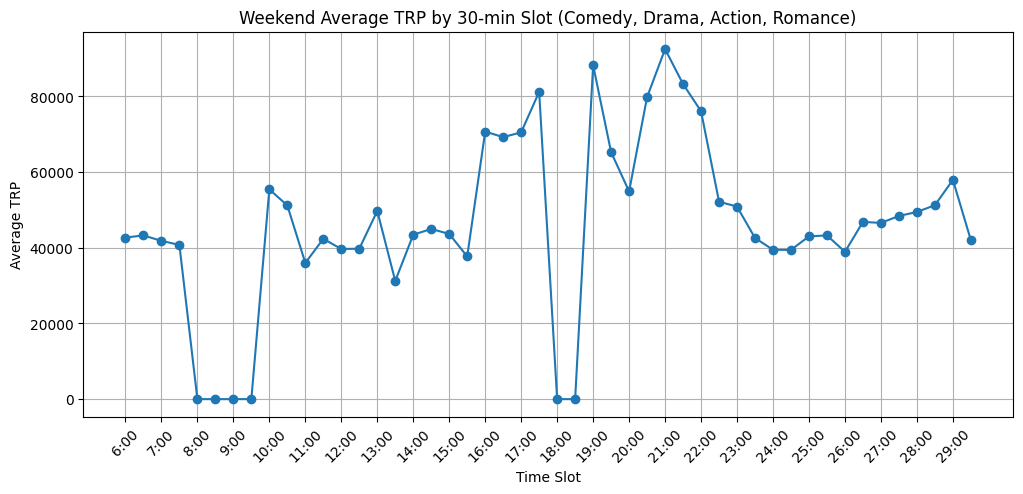

In [23]:
# Genres to include
genres_of_interest = ['Comedy', 'Drama', 'Action', 'Romance']
filtered_trp = avg_trp[(avg_trp['Is_Weekend']==1) & (avg_trp['Genre'].isin(genres_of_interest))]

# Average TRP per slot
weekend_avg = filtered_trp.groupby('Slot_Index')['TRP'].mean()

# Reindex to ensure all 48 slots exist, fill missing slots with 0
weekend_avg = weekend_avg.reindex(range(48), fill_value=0)

# Plot
plt.figure(figsize=(12,5))
plt.plot(range(48), weekend_avg, marker='o')
plt.xticks(
    ticks=range(0,48,2), 
    labels=[f"{6+i//2}:{(i%2)*30:02d}" for i in range(0,48,2)], 
    rotation=45
)
plt.xlabel("Time Slot")
plt.ylabel("Average TRP")
plt.title("Weekend Average TRP by 30-min Slot (Comedy, Drama, Action, Romance)")
plt.grid(True)
plt.show()

In [ ]:
# # Example: weekend, relevant genres, prime-time only
# prime_slots = range(18, 44)  # 15:00 - 23:00
# filtered_trp = avg_trp[
#     (avg_trp['Is_Weekend']==1) &
#     (avg_trp['Genre'].isin(genres_of_interest)) &
#     (avg_trp['Slot_Index'].isin(prime_slots))
# ]


### weekend visualization of interested genres

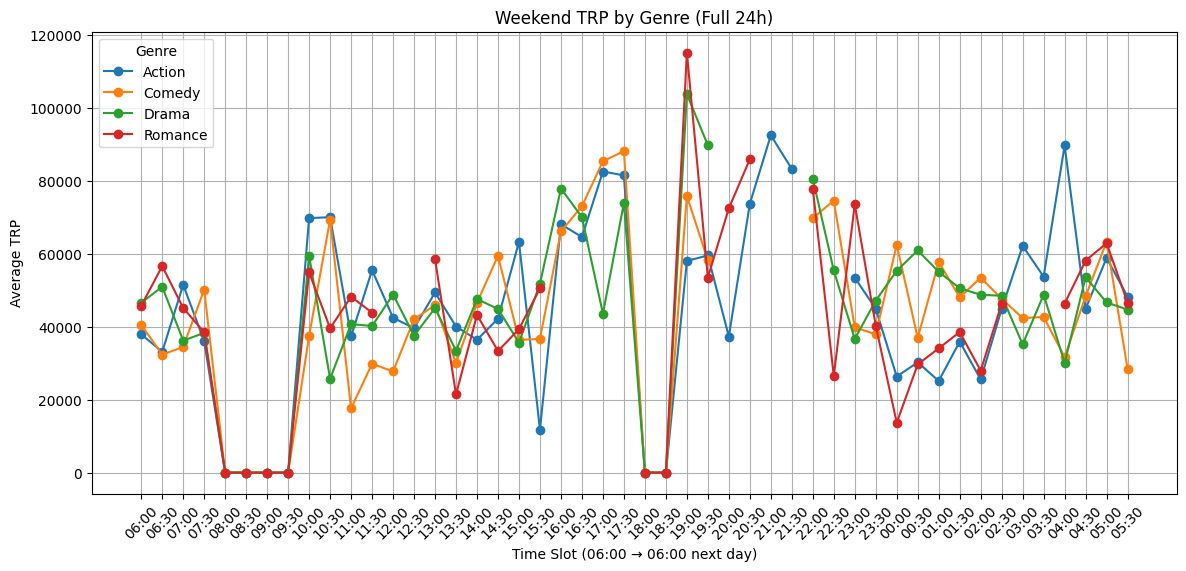

In [25]:
# Select genres and weekend only
genres_of_interest = ['Comedy', 'Drama', 'Action', 'Romance']
filtered_trp = avg_trp[
    (avg_trp['Is_Weekend']==1) &
    (avg_trp['Genre'].isin(genres_of_interest))
]

# Group by Slot_Index and Genre, get average TRP
TRP_avg_by_genre = filtered_trp.groupby(['Slot_Index','Genre'])['TRP'].mean().unstack()

# Make sure all 48 slots exist (06:00 → 06:00 next day)
TRP_avg_by_genre = TRP_avg_by_genre.reindex(range(48), fill_value=0)

# Function to convert Slot_Index to HH:MM
def slot_to_time(slot):
    total_minutes = 6*60 + slot*30
    hours = (total_minutes // 60) % 24
    minutes = total_minutes % 60
    return f"{hours:02d}:{minutes:02d}"

# Full 48-slot labels for x-axis
slot_labels = [slot_to_time(i) for i in range(48)]

# Plot
plt.figure(figsize=(14,6))
TRP_avg_by_genre.plot(marker='o', ax=plt.gca())
plt.xticks(ticks=range(48), labels=slot_labels, rotation=45)
plt.xlabel("Time Slot (06:00 → 06:00 next day)")
plt.ylabel("Average TRP")
plt.title("Weekend TRP by Genre (Full 24h)")
plt.grid(True)
plt.show()


### weekday visualization of interested genres

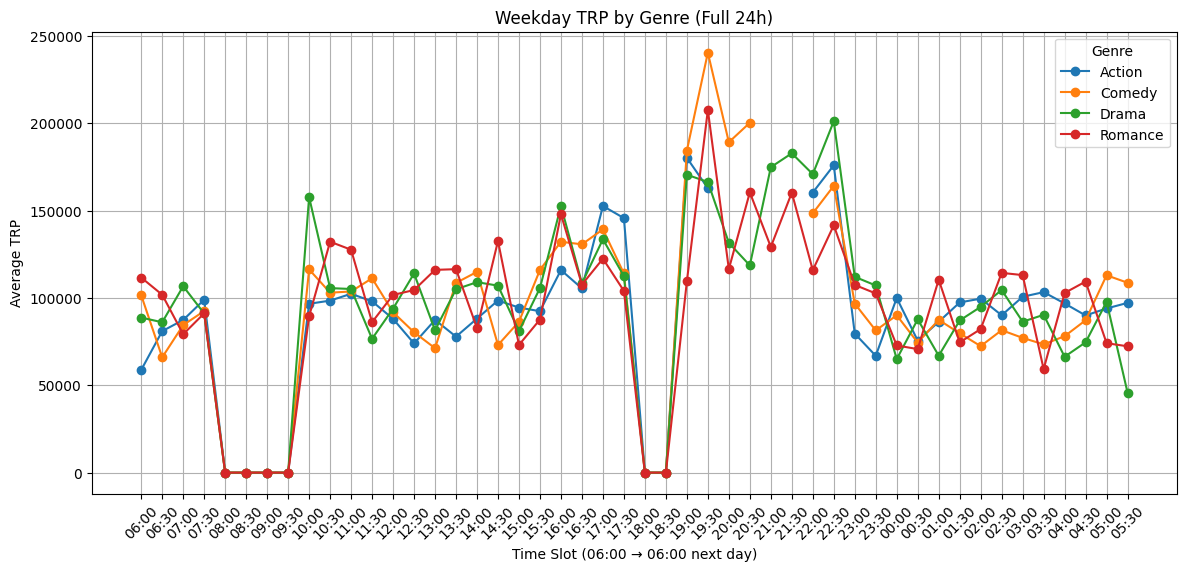

In [26]:
# Select genres and weekend only
genres_of_interest = ['Comedy', 'Drama', 'Action', 'Romance']
filtered_trp = avg_trp[
    (avg_trp['Is_Weekend']==0) &
    (avg_trp['Genre'].isin(genres_of_interest))
]

# Group by Slot_Index and Genre, get average TRP
TRP_avg_by_genre = filtered_trp.groupby(['Slot_Index','Genre'])['TRP'].mean().unstack()

# Make sure all 48 slots exist (06:00 → 06:00 next day)
TRP_avg_by_genre = TRP_avg_by_genre.reindex(range(48), fill_value=0)

# Function to convert Slot_Index to HH:MM
def slot_to_time(slot):
    total_minutes = 6*60 + slot*30
    hours = (total_minutes // 60) % 24
    minutes = total_minutes % 60
    return f"{hours:02d}:{minutes:02d}"

# Full 48-slot labels for x-axis
slot_labels = [slot_to_time(i) for i in range(48)]

# Plot
plt.figure(figsize=(14,6))
TRP_avg_by_genre.plot(marker='o', ax=plt.gca())
plt.xticks(ticks=range(48), labels=slot_labels, rotation=45)
plt.xlabel("Time Slot (06:00 → 06:00 next day)")
plt.ylabel("Average TRP")
plt.title("Weekday TRP by Genre (Full 24h)")
plt.grid(True)
plt.show()


### unused forbidden slots for focused genres

In [28]:
TRP_avg_by_genre = avg_trp.groupby(['Slot_Index','Genre'])['TRP'].mean().unstack()

In [29]:
TRP_avg_by_genre = avg_trp.groupby(['Slot_Index','Genre'])['TRP'].mean().unstack()
# Genres you care about
genres_of_interest = ["Action", "Comedy", "Drama", "Romance"]

# Filter TRP data only for them
filtered = avg_trp[ avg_trp["Genre"].isin(genres_of_interest) ]

# Compute mean TRP per slot per genre
TRP_avg_by_genre = (
    filtered
    .groupby(["Slot_Index", "Genre"])["TRP"]
    .mean()
    .unstack(fill_value=0)
)

# Ensure all 48 slots exist (06:00 → next-day 06:00)
TRP_avg_by_genre = TRP_avg_by_genre.reindex(range(48), fill_value=0)

# Forbidden slot detection threshold
# You can tune this later (0 = only slots with zero TRP)
threshold_factor = 0.10  # bottom 10% becomes forbidden

forbidden_slots = {}

for genre in genres_of_interest:
    # TRP series for that genre
    trp_series = TRP_avg_by_genre[genre]

    # Compute threshold (bottom 10% TRP)
    cutoff = trp_series.quantile(threshold_factor)

    # Forbidden = slots where TRP <= threshold
    forbidden = trp_series.index[trp_series <= cutoff].tolist()

    forbidden_slots[genre] = forbidden

In [30]:
forbidden_slots

{'Action': [4, 5, 6, 7, 24, 25],
 'Comedy': [4, 5, 6, 7, 24, 25, 30, 31],
 'Drama': [4, 5, 6, 7, 24, 25],
 'Romance': [4, 5, 6, 7, 24, 25]}

#### Top peak hour slots

In [31]:
# Average TRP per slot for each genre

genres_of_interest = ["Action", "Comedy", "Drama", "Romance"]

# Filter TRP data only for them
filtered = avg_trp[ avg_trp["Genre"].isin(genres_of_interest) ]

trp_by_slot_genre = filtered.groupby(['Genre', 'Slot_Index'])['TRP'].mean().reset_index()
peak_slot_per_genre = (
    trp_by_slot_genre.loc[trp_by_slot_genre.groupby('Genre')['TRP'].idxmax()]
    .reset_index(drop=True)
)

In [32]:
peak_slot_per_genre

,Genre,Slot_Index,TRP
0,Action,33,175965.000000
1,Comedy,29,200313.666667
2,Drama,31,182817.666667
3,Romance,31,160266.666667


In [33]:
def compute_peak_slots(df, top_n=5):
    genres_of_interest = ["Action", "Comedy", "Drama", "Romance"]

    # Filter TRP data only for them
    filtered = df[ df["Genre"].isin(genres_of_interest) ]
    t = filtered.groupby(['Genre','Slot_Index'])['TRP'].mean().reset_index()
    return (
        t.sort_values(['Genre','TRP'], ascending=[True, False])
         .groupby('Genre')
         .head(top_n)
         .groupby('Genre')['Slot_Index']
         .apply(list)
         .to_dict()
    )

weekday_peak_slots = compute_peak_slots(avg_trp[avg_trp['Is_Weekend']==0])
weekend_peak_slots = compute_peak_slots(avg_trp[avg_trp['Is_Weekend']==1])

weekday_peak_slots
# weekend_peak_slots 


{'Action': [26, 33, 27, 32, 22],
 'Comedy': [27, 29, 28, 26, 33],
 'Drama': [33, 31, 30, 32, 26],
 'Romance': [27, 29, 31, 20, 33]}

In [34]:
def compute_forbidden_slots(df, genres, threshold_factor=0.10):
    """
    Computes forbidden slots for each genre based on low TRP.
    - df must include columns: Slot_Index, Genre, TRP
    - threshold_factor: bottom x% of TRP becomes forbidden
    """

    # Filter only the genres you care about
    filtered = df[df["Genre"].isin(genres)]

    # Compute TRP averages pivot: rows = slot, cols = genre
    TRP_avg_by_genre = (
        filtered
        .groupby(["Slot_Index", "Genre"])["TRP"]
        .mean()
        .unstack(fill_value=0)
    )

    # Ensure 48 slots (06:00 → next-day 06:00)
    TRP_avg_by_genre = TRP_avg_by_genre.reindex(range(48), fill_value=0)

    forbidden_slots = {}

    # Compute forbidden slots per genre
    for genre in genres:
        trp_series = TRP_avg_by_genre[genre]

        # Bottom X% TRP threshold (default = bottom 10%)
        cutoff = trp_series.quantile(threshold_factor)

        # Forbidden = TRP <= cutoff
        forbidden = trp_series.index[trp_series <= cutoff].tolist()

        forbidden_slots[genre] = forbidden

    return forbidden_slots


# === GENRES OF INTEREST ===
genres_of_interest = ["Action", "Comedy", "Drama", "Romance"]

# === WEEKDAY DATA (Is_Weekend = 0) ===
weekday_df = avg_trp[avg_trp["Is_Weekend"] == 0]
weekday_forbidden_slots = compute_forbidden_slots(weekday_df, genres_of_interest)

# === WEEKEND DATA (Is_Weekend = 1) ===
weekend_df = avg_trp[avg_trp["Is_Weekend"] == 1]
weekend_forbidden_slots = compute_forbidden_slots(weekend_df, genres_of_interest)

print("Weekday Forbidden Slots:")
print(weekday_forbidden_slots)

print("\nWeekend Forbidden Slots:")
print(weekend_forbidden_slots)

Weekday Forbidden Slots:
{'Action': [4, 5, 6, 7, 24, 25, 28, 29, 30, 31], 'Comedy': [4, 5, 6, 7, 24, 25, 30, 31], 'Drama': [4, 5, 6, 7, 24, 25], 'Romance': [4, 5, 6, 7, 24, 25]}

Weekend Forbidden Slots:
{'Action': [4, 5, 6, 7, 24, 25, 32, 33], 'Comedy': [4, 5, 6, 7, 24, 25, 28, 29, 30, 31], 'Drama': [4, 5, 6, 7, 24, 25, 28, 29, 30, 31], 'Romance': [4, 5, 6, 7, 12, 13, 20, 21, 22, 23, 24, 25, 30, 31, 42, 43]}


### only keep the genres of interest

In [35]:
# Only keep rows for the genres we care about
genres_of_interest = ['Comedy', 'Drama', 'Action', 'Romance']
filtered_trp = slot_trp[slot_trp['Genre'].isin(genres_of_interest)].copy()

# Remove slots where TRP is zero across all these genres
# Step 1: Compute sum TRP per Slot_Index for genres of interest
trp_per_slot = filtered_trp.groupby('Slot_Index')['TRP'].sum()

# Step 2: Keep only slots where total TRP > 0
valid_slots = trp_per_slot[trp_per_slot > 0].index
filtered_trp = filtered_trp[filtered_trp['Slot_Index'].isin(valid_slots)].copy()



In [36]:

# Normalize TRP per Genre + Is_Weekend (Min-Max scaling)
filtered_trp['TRP_scaled'] = filtered_trp.groupby(['Genre','Is_Weekend'])['TRP'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
)


In [37]:
filtered_trp.describe()

,Slot_Index,Day_of_Week,TRP,Is_Weekend,TRP_scaled
count,1178.000000,1178.000000,1178.000000,1178.000000,1178.000000
mean,24.683362,3.162988,87899.591681,0.312394,0.333621
std,14.225723,1.987366,49616.684384,0.463666,0.192554
min,0.000000,0.000000,8863.000000,0.000000,0.000000
25%,13.000000,1.000000,51033.250000,0.000000,0.191035
50%,22.500000,3.000000,77475.000000,0.000000,0.295430
75%,38.000000,5.000000,113341.000000,1.000000,0.444309
max,47.000000,6.000000,300116.000000,1.000000,1.000000


In [38]:
filtered_trp['Genre'].unique()

array(['Drama', 'Action', 'Romance', 'Comedy'], dtype=object)

In [39]:
llm_df = filtered_trp.copy()

# Create an LLM to generate extra metadata for our programs

In [75]:

# -----------------------------
# 1. Load your dataset
# -----------------------------
df_metadata = pd.read_csv("viewership_tv_aug.csv")   # Change to your filename

oai_api_key = openai_api_key

client = OpenAI(api_key = oai_api_key )

# -----------------------------
# 2. LLM function to generate metadata
# -----------------------------
def get_show_metadata(show_name):
    prompt = f"""
You are a TV programming expert.  

For the TV show "{show_name}", generate **concise metadata** suitable for program placement analysis.  

**Requirements:**
1. **Subgenre**: Use one of the following codes:
   - 0 = Drama
   - 1 = Comedy
   - 2 = Action
   - 3 = Romance
   - 4 = Sci-Fi/Thriller
   - 5 = Reality/Other

2. **Tone/Energy**: Use one of these codes:
   - 0 = Lighthearted/Funny
   - 1 = Suspenseful/Tense
   - 2 = Dark/Intense
   - 3 = Witty/Irreverent
   - 4 = Emotional/Reflective

3. **Violence**: Use codes only:
   - 0 = None
   - 1 = Low
   - 2 = Medium
   - 3 = High

4. **Theme**: Pick **one main theme** and encode it as a number based on this fixed list:
   - 0 = friendship
   - 1 = love
   - 2 = betrayal
   - 3 = survival
   - 4 = justice
   - 5 = family

5. **Target Age**: integer (minimum recommended age).

**Output format (one line, comma-separated, no extra text):**
Subgenre_code,Tone_code,Violence_code,Theme_code,Age  

**Example output:**  
0,1,2,0,14
"""

    
    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    
    return response.choices[0].message.content.strip()

# -----------------------------
# 3. Create empty metadata columns
# -----------------------------
metadata_cols = ["Subgenre", "Tone", "Violence", "Themes", "Age"]
for col in metadata_cols:
    if col not in df_metadata.columns:
        df_metadata[col] = None

# -----------------------------
# 4. Process each unique program
# -----------------------------
unique_programs = df["ProgramName"].unique()
metadata_dict = {}

for show in unique_programs:
    print("Processing:", show)
    try:
        line = get_show_metadata(show)  # "Drama, suspenseful, medium, friendship;danger, 14"
        parts = [p.strip() for p in line.split(",")]
        metadata_dict[show] = {
            "Subgenre": parts[0],
            "Tone": parts[1],
            "Violence": parts[2],
            "Themes": parts[3],
            "Age": parts[4]
        }
    except Exception as e:
        print(f"⚠️ Error for {show} — {e}")
        metadata_dict[show] = {
            "Subgenre": None,
            "Tone": None,
            "Violence": None,
            "Themes": None,
            "Age": None
        }

# -----------------------------
# 5. Map metadata back to dataframe
# -----------------------------
for col in metadata_cols:
    df_metadata[col] = df_metadata["ProgramName"].map(lambda x: metadata_dict[x][col])

# -----------------------------
# 6. Save the enriched dataset
# -----------------------------
df_metadata.to_csv("viewership_with_metadata.csv", index=False)
print("🎉 Done! Metadata columns added per program.")

Processing: Stranger Things
Processing: Vikings
Processing: Squid Game
Processing: House
Processing: The Office
Processing: Bridgerton
Processing: Good Morning America
Processing: Breaking Bad
Processing: The Sopranos
Processing: Suits
Processing: The News
Processing: The Walking Dead
Processing: Football Match
Processing: The Big Bang Theory
Processing: How I Met Your Mother
Processing: Grey's Anatomy
Processing: Peaky Blinders
Processing: Friends
Processing: Game Of Thrones
Processing: Modern Family
🎉 Done! Metadata columns added per program.


In [41]:
df_metadata.head(1)

,Unnamed: 0,Date,Time,ProgramName,Genre,Episode,TRP,Subgenre,Tone,Violence,Themes,Age
0,0,2025-08-01,00:00,Stranger Things,Drama,1,"66,957",4,2,2,3,14


## Merge the histrocial data with the new metadata

In [42]:

# Merge metadata into filtered_trp
llm_df = llm_df.merge(
    df_metadata[['ProgramName', 'Subgenre', 'Tone', 'Violence', 'Themes', 'Age']],
    on='ProgramName',
    how='left'
)



In [43]:
# Check the result
llm_df.head(2)

,TV_Date,Slot_Index,Genre,ProgramName,Day_of_Week,TRP,Is_Weekend,TRP_scaled,Subgenre,Tone,Violence,Themes,Age
0,2025-07-31,36,Drama,Stranger Things,3,83004,0,0.243586,4,2,2,3,14
1,2025-07-31,36,Drama,Stranger Things,3,83004,0,0.243586,4,2,2,3,14


In [44]:
llm_df['Violence'].unique()

array(['2', '3', '1', '0'], dtype=object)

# Make the metadata numerical so I can fit it into the Genetic Algorithm

In [45]:
# Create a copy of your enriched dataframe
ga_df = llm_df.copy()

In [46]:
ga_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256020 entries, 0 to 256019
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TV_Date      256020 non-null  object 
 1   Slot_Index   256020 non-null  int64  
 2   Genre        256020 non-null  object 
 3   ProgramName  256020 non-null  object 
 4   Day_of_Week  256020 non-null  int32  
 5   TRP          256020 non-null  int64  
 6   Is_Weekend   256020 non-null  int64  
 7   TRP_scaled   256020 non-null  float64
 8   Subgenre     256020 non-null  object 
 9   Tone         256020 non-null  object 
 10  Violence     256020 non-null  object 
 11  Themes       256020 non-null  object 
 12  Age          256020 non-null  object 
dtypes: float64(1), int32(1), int64(3), object(8)
memory usage: 24.4+ MB


In [47]:
ga_df.isna().sum()

TV_Date        0
Slot_Index     0
Genre          0
ProgramName    0
Day_of_Week    0
TRP            0
Is_Weekend     0
TRP_scaled     0
Subgenre       0
Tone           0
Violence       0
Themes         0
Age            0
dtype: int64

# Building an optimization Algoirthm 

### First open the new programs and put the necesssary metadata that we need

In [76]:
# -----------------------------
# 1. Read new shows from txt
# -----------------------------
programs = []
with open("programs_to_place.txt", "r") as f:
    for line in f.read().splitlines():
        if "(" in line and ")" in line:
            name = line.split("(")[0].strip()
            genre = line.split("(")[1].replace(")", "").strip()
            programs.append({"ProgramName": name, "Genre": genre})

new_shows_df = pd.DataFrame(programs)
print(new_shows_df)

# -----------------------------
# 2. OpenAI client
# -----------------------------
oai_api_key = openai_api_key

client = OpenAI(api_key=oai_api_key)

# -----------------------------
# 3. LLM function (reuse)
# -----------------------------
def get_show_metadata(show_name):
    prompt = f"""
You are a TV programming expert.  

For the TV show "{show_name}", generate **concise metadata** suitable for program placement analysis.  

**Requirements:**
1. **Subgenre**: Use one of the following codes:
   - 0 = Drama
   - 1 = Comedy
   - 2 = Action
   - 3 = Romance
   - 4 = Sci-Fi/Thriller
   - 5 = Reality/Other

2. **Tone/Energy**: Use one of these codes:
   - 0 = Lighthearted/Funny
   - 1 = Suspenseful/Tense
   - 2 = Dark/Intense
   - 3 = Witty/Irreverent
   - 4 = Emotional/Reflective

3. **Violence**: Use codes only:
   - 0 = None
   - 1 = Low
   - 2 = Medium
   - 3 = High

4. **Theme**: Pick **one main theme** and encode it as a number based on this fixed list:
   - 0 = friendship
   - 1 = love
   - 2 = betrayal
   - 3 = survival
   - 4 = justice
   - 5 = family

5. **Target Age**: integer (minimum recommended age).

**Output format (one line, comma-separated, no extra text):**
Subgenre_code,Tone_code,Violence_code,Theme_code,Age  

**Example output:**  
0,1,2,0,14
"""
    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.choices[0].message.content.strip()

# -----------------------------
# 4. Generate metadata for new shows
# -----------------------------
metadata_cols = ["Subgenre", "Tone", "Violence", "Themes", "Age"]
metadata_dict = {}

for show in new_shows_df["ProgramName"]:
    print("Processing:", show)
    try:
        line = get_show_metadata(show)
        parts = [p.strip() for p in line.split(",")]
        metadata_dict[show] = {
            "Subgenre": parts[0],
            "Tone": parts[1],
            "Violence": parts[2],
            "Themes": parts[3],
            "Age": parts[4]
        }
    except Exception as e:
        print(f"⚠️ Error for {show} — {e}")
        metadata_dict[show] = {col: None for col in metadata_cols}

# -----------------------------
# 5. Map metadata to dataframe
# -----------------------------
for col in metadata_cols:
    new_shows_df[col] = new_shows_df["ProgramName"].map(lambda x: metadata_dict[x][col])

# -----------------------------
# 6. Save the new shows with metadata
# -----------------------------
new_shows_df.to_csv("new_shows_with_metadata.csv", index=False)
print("🎉 Done! Metadata added for new shows.")

            ProgramName    Genre
0              Seinfeld   Comedy
1  Arrested Development   Comedy
2    Brooklyn Nine-Nine   Comedy
3             The Crown    Drama
4              The Wire    Drama
5               Mad Men    Drama
6       The Mandalorian   Action
7              The Boys   Action
8          Prison Break   Action
9             Outlander  Romance
Processing: Seinfeld
Processing: Arrested Development
Processing: Brooklyn Nine-Nine
Processing: The Crown
Processing: The Wire
Processing: Mad Men
Processing: The Mandalorian
Processing: The Boys
Processing: Prison Break
Processing: Outlander
🎉 Done! Metadata added for new shows.


In [49]:
new_shows_df.head(1)

,ProgramName,Genre,Subgenre,Tone,Violence,Themes,Age
0,Seinfeld,Comedy,1,0,0,0,12


In [50]:
genre_map = {v:i for i,v in enumerate(ga_df['Genre'].unique())}
ga_df['Genre_enc'] = ga_df['Genre'].map(genre_map)

In [51]:
new_shows_df['Genre_enc'] = new_shows_df['Genre'].map(genre_map)

In [52]:
new_shows_df.isna().sum()

ProgramName    0
Genre          0
Subgenre       0
Tone           0
Violence       0
Themes         0
Age            0
Genre_enc      0
dtype: int64

In [53]:
ga_df.head(1)

,TV_Date,Slot_Index,Genre,ProgramName,Day_of_Week,TRP,Is_Weekend,TRP_scaled,Subgenre,Tone,Violence,Themes,Age,Genre_enc
0,2025-07-31,36,Drama,Stranger Things,3,83004,0,0.243586,4,2,2,3,14,0


In [54]:
new_shows_df.head(1)

,ProgramName,Genre,Subgenre,Tone,Violence,Themes,Age,Genre_enc
0,Seinfeld,Comedy,1,0,0,0,12,3


In [56]:
ga_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256020 entries, 0 to 256019
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TV_Date      256020 non-null  object 
 1   Slot_Index   256020 non-null  int64  
 2   Genre        256020 non-null  object 
 3   ProgramName  256020 non-null  object 
 4   Day_of_Week  256020 non-null  int32  
 5   TRP          256020 non-null  int64  
 6   Is_Weekend   256020 non-null  int64  
 7   TRP_scaled   256020 non-null  float64
 8   Subgenre     256020 non-null  object 
 9   Tone         256020 non-null  object 
 10  Violence     256020 non-null  object 
 11  Themes       256020 non-null  object 
 12  Age          256020 non-null  object 
 13  Genre_enc    256020 non-null  int64  
dtypes: float64(1), int32(1), int64(4), object(8)
memory usage: 26.4+ MB


In [57]:
# Convert all encoded columns to int
encoded_cols = ["Subgenre", "Tone", "Violence", "Themes", "Age"]
for col in encoded_cols:
    ga_df[col] = ga_df[col].astype(int)

In [58]:
ga_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256020 entries, 0 to 256019
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TV_Date      256020 non-null  object 
 1   Slot_Index   256020 non-null  int64  
 2   Genre        256020 non-null  object 
 3   ProgramName  256020 non-null  object 
 4   Day_of_Week  256020 non-null  int32  
 5   TRP          256020 non-null  int64  
 6   Is_Weekend   256020 non-null  int64  
 7   TRP_scaled   256020 non-null  float64
 8   Subgenre     256020 non-null  int64  
 9   Tone         256020 non-null  int64  
 10  Violence     256020 non-null  int64  
 11  Themes       256020 non-null  int64  
 12  Age          256020 non-null  int64  
 13  Genre_enc    256020 non-null  int64  
dtypes: float64(1), int32(1), int64(9), object(3)
memory usage: 26.4+ MB


In [59]:
# ga_df['TRP_scaled'] = ga_df['TRP_scaled'].astype(int)

In [60]:
ga_df.head(1)

,TV_Date,Slot_Index,Genre,ProgramName,Day_of_Week,TRP,Is_Weekend,TRP_scaled,Subgenre,Tone,Violence,Themes,Age,Genre_enc
0,2025-07-31,36,Drama,Stranger Things,3,83004,0,0.243586,4,2,2,3,14,0


### Finding Peak and Forbidden time ( Forbidden timings are timings that were never shown in the historical data)

In [ ]:
# HELPER FUNCTIONS
# -----------------------------
# -----------------------------
def compute_forbidden_slots(df, genres, num_slots=48, threshold_factor=0.10):
    """
    Computes forbidden slots per genre, considering missing slots as TRP=0.
    """
    forbidden_slots = {}

    for genre in genres:
        # Filter for this genre
        trp_series = df[df['Genre'] == genre].groupby('Slot_Index')['TRP'].mean()

        # Reindex to all slots, missing slots → TRP = 0
        trp_series = trp_series.reindex(range(num_slots), fill_value=0)

        # Bottom X% TRP threshold
        cutoff = trp_series.quantile(threshold_factor)

        # Forbidden slots = TRP <= cutoff
        forbidden = trp_series.index[trp_series <= cutoff].tolist()
        forbidden_slots[genre] = forbidden

    return forbidden_slots


def compute_peak_slots(df, genres, threshold_factor=0.10):
    """
    Returns peak slots per genre based on high TRP (top X%).
    """
    peak_slots = {}
    filtered = df[df["Genre"].isin(genres)]

    for genre in genres:
        trp_series = filtered[filtered["Genre"]==genre].groupby("Slot_Index")["TRP"].mean()
        cutoff = trp_series.quantile(1-threshold_factor)
        peaks = trp_series.index[trp_series >= cutoff].tolist()
        peak_slots[genre] = peaks

    return peak_slots


weekday_template = ga_df[ga_df['Is_Weekend']==0].groupby('Subgenre').first().reset_index()
weekend_template = ga_df[ga_df['Is_Weekend']==1].groupby('Subgenre').first().reset_index()

# -----------------------------
# FORBIDDEN & PEAK SLOTS
# -----------------------------
genres_of_interest = ["Action", "Comedy", "Drama", "Romance"]

weekday_forbidden_slots = compute_forbidden_slots(avg_trp[avg_trp["Is_Weekend"]==0], genres_of_interest)
weekend_forbidden_slots = compute_forbidden_slots(avg_trp[avg_trp["Is_Weekend"]==1], genres_of_interest)


weekday_peak_slots = compute_peak_slots(avg_trp[avg_trp["Is_Weekend"]==0], genres_of_interest)
weekend_peak_slots = compute_peak_slots(avg_trp[avg_trp["Is_Weekend"]==1], genres_of_interest)

print("weekday_peak_slots", weekday_peak_slots)
print("weekend_peak_slots", weekend_peak_slots)

print("weekday_forbidden_slots", weekday_forbidden_slots)
print("weekend_forbidden_slots", weekend_forbidden_slots)

## Create Genetic Algorithm and fill the grid

In [61]:
ga_df['TRP_scaled'].describe()

count    256020.000000
mean          0.332116
std           0.192004
min           0.000000
25%           0.190770
50%           0.294272
75%           0.441061
max           1.000000
Name: TRP_scaled, dtype: float64

In [62]:
# df = pd.read_csv("your_file.csv")  

# Convert DataFrame to JSON-like Python object
new_shows_json = new_shows_df.to_dict(orient="records")

# Example: see first 3 entries
print(new_shows_json[:3])

[{'ProgramName': 'Seinfeld', 'Genre': 'Comedy', 'Subgenre': '1', 'Tone': '0', 'Violence': '0', 'Themes': '0', 'Age': '12', 'Genre_enc': 3}, {'ProgramName': 'Arrested Development', 'Genre': 'Comedy', 'Subgenre': '1', 'Tone': '3', 'Violence': '0', 'Themes': '5', 'Age': '13', 'Genre_enc': 3}, {'ProgramName': 'Brooklyn Nine-Nine', 'Genre': 'Comedy', 'Subgenre': '1', 'Tone': '0', 'Violence': '1', 'Themes': '4', 'Age': '12', 'Genre_enc': 3}]


In [63]:
# new_shows_json

### Genetic Algorithm is not the most optimal answer, data is too small and has alot of constraints

In [65]:
# import pandas as pd
# import random

# # --- Parameters ---
# POP_SIZE = 50
# GENERATIONS = 100
# MUTATION_RATE = 0.3
# ELITE_SIZE = 5
# NUM_SLOTS = 48  # 24 hours * 2 (30-min slots) from 06:00 to next 06:00
# DAYS = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# # --- Generate time slot labels (e.g. "06:00-06:30") ---
# def generate_time_labels(start_hour=6, num_slots=NUM_SLOTS, slot_minutes=30):
#     labels = []
#     for i in range(num_slots):
#         total_start = start_hour*60 + i*slot_minutes
#         total_end = total_start + slot_minutes
#         start_h = (total_start // 60) % 24
#         start_m = total_start % 60
#         end_h = (total_end // 60) % 24
#         end_m = total_end % 60
#         labels.append(f"{start_h:02d}:{start_m:02d}-{end_h:02d}:{end_m:02d}")
#     return labels

# TIME_LABELS = generate_time_labels()

# # --- Forbidden/Peak slot computation ---
# def compute_forbidden_slots(df, genres, threshold=0.10):
#     forbidden = {}
#     for g in genres:
#         trp = df[df['Genre']==g].groupby('Slot_Index')['TRP'].mean()
#         trp = trp.reindex(range(NUM_SLOTS), fill_value=0)
#         cutoff = trp.quantile(threshold)
#         # slots at or below the cutoff TRP are considered "forbidden"
#         forbidden[g] = trp.index[trp <= cutoff].tolist()
#     return forbidden

# def compute_peak_slots(df, genres, threshold=0.10):
#     peak = {}
#     for g in genres:
#         trp = df[df['Genre']==g].groupby('Slot_Index')['TRP'].mean()
#         trp = trp.reindex(range(NUM_SLOTS), fill_value=0)
#         cutoff = trp.quantile(1 - threshold)
#         # slots at or above the cutoff TRP are "peak"
#         peak[g] = trp.index[trp >= cutoff].tolist()
#     return peak

# # --- Population Initialization ---
# def generate_population(shows_json, weekday_forbidden, weekend_forbidden):
#     population = []
#     for _ in range(POP_SIZE):
#         chrom = []
#         for prog in shows_json:
#             # Determine weekday vs weekend from original data (Day_of_Week)
#             is_weekend = 1 if prog.get('Day_of_Week') in [5,6] else 0
#             duration = 4 if is_weekend else 2
#             forbidden = weekend_forbidden if is_weekend else weekday_forbidden

#             # Valid start slots where no part is in forbidden slots
#             all_slots = list(range(NUM_SLOTS - duration + 1))
#             valid_slots = [
#                 s for s in all_slots
#                 if all(slot not in forbidden.get(prog['Genre'], []) 
#                        for slot in range(s, s+duration))
#             ]
#             if valid_slots:
#                 start_slot = random.choice(valid_slots)
#             else:
#                 # Fallback: pick a random start that at least doesn't *begin* in a forbidden slot
#                 possible_starts = [s for s in all_slots if s not in forbidden.get(prog['Genre'], [])]
#                 start_slot = random.choice(possible_starts) if possible_starts else random.randint(0, NUM_SLOTS-duration)
            
#             gene = {
#                 "ProgramName": prog["ProgramName"],
#                 "Template": {
#                     "Slot_Index": start_slot,
#                     "Duration": duration,
#                     "Genre": prog["Genre"],
#                     "Subgenre": prog.get("Subgenre","Unknown"),
#                     "Tone": prog.get("Tone","Unknown"),
#                     "Violence": prog.get("Violence","Unknown"),
#                     "Themes": prog.get("Themes","Unknown"),
#                     "Genre_enc": prog.get("Genre_enc",0)
#                 },
#                 "Is_Weekend": is_weekend
#             }
#             chrom.append(gene)
#         population.append(chrom)
#     return population

# # --- Fitness evaluation ---
# def fitness(chrom, weekday_forbidden, weekend_forbidden, weekday_peak, weekend_peak):
#     total_score = 0
#     # Penalize forbidden slots and reward peaks; encourage diversity between adjacent genes
#     for i, gene in enumerate(chrom):
#         temp = gene['Template']
#         start = temp['Slot_Index']
#         dur = temp['Duration']
#         genre = temp['Genre']
#         is_weekend = gene['Is_Weekend']

#         forbidden = weekend_forbidden if is_weekend else weekday_forbidden
#         peak = weekend_peak if is_weekend else weekday_peak

#         # Hard penalty if any part overlaps forbidden
#         if any(slot in forbidden.get(genre, []) for slot in range(start, start+dur)):
#             total_score -= 100  # large penalty
        
#         # Peak-time bonus if starting in a peak slot
#         if start in peak.get(genre, []):
#             total_score += 10

#         # Soft diversity bonuses with the previous gene
#         if i > 0:
#             prev = chrom[i-1]['Template']
#             # total_score += 2  if prev["Subgenre"] != temp["Subgenre"] else 0
#             total_score += 1  if prev["Tone"]     != temp["Tone"]     else 0
#             total_score += 1  if prev["Violence"] != temp["Violence"] else 0
#             total_score += 1  if prev["Themes"]   != temp["Themes"]   else 0
#             total_score += 2.5 if prev["Genre_enc"] == temp["Genre_enc"] else 0

#     # Hard penalty for any overlap: build a time-day occupancy grid
#     grid = pd.DataFrame('', index=TIME_LABELS, columns=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
#     for gene in chrom:
#         start = gene['Template']['Slot_Index']
#         dur = gene['Template']['Duration']
#         days = ['Sat','Sun'] if gene['Is_Weekend'] else ['Mon','Tue','Wed','Thu','Fri']
#         for d in days:
#             for off in range(dur):
#                 if grid.iloc[start+off][d] != '':
#                     total_score -= 1000  # very large penalty for overlap
#                 grid.iloc[start+off][d] = gene['ProgramName']
#     return total_score

# # --- GA operators ---
# def selection(pop, weekday_forbidden, weekend_forbidden, weekday_peak, weekend_peak):
#     # Sort by fitness (higher is better) and keep top ELITE_SIZE
#     scored = sorted(pop, key=lambda c: fitness(c, weekday_forbidden, weekend_forbidden, weekday_peak, weekend_peak), reverse=True)
#     return scored[:ELITE_SIZE]

# def crossover(p1, p2):
#     size = len(p1)
#     a, b = sorted(random.sample(range(size), 2))
#     child = [None]*size
#     # Copy a slice from p1
#     child[a:b] = [g.copy() for g in p1[a:b]]
#     used = {g['ProgramName'] for g in child[a:b] if g}
#     idx = 0
#     # Fill remaining genes in order from p2
#     for gene in p2:
#         if gene['ProgramName'] in used:
#             continue
#         while idx < size and child[idx] is not None:
#             idx += 1
#         if idx < size:
#             child[idx] = gene.copy()
#             used.add(gene['ProgramName'])
#     # If any None remain (shouldn't), fill from p1/p2 sequentially
#     for gene in p1 + p2:
#         if gene['ProgramName'] not in used:
#             for i in range(size):
#                 if child[i] is None:
#                     child[i] = gene.copy()
#                     used.add(gene['ProgramName'])
#                     break
#     return child

# def mutate(chrom):
#     if random.random() < MUTATION_RATE:
#         if random.random() < 0.5:
#             # Swap two genes
#             i, j = random.sample(range(len(chrom)), 2)
#             chrom[i], chrom[j] = chrom[j], chrom[i]
#         else:
#             # Mutate one gene's start time
#             i = random.randrange(len(chrom))
#             gene = chrom[i]
#             is_weekend = gene['Is_Weekend']
#             duration = gene['Template']['Duration']
#             genre = gene['Template']['Genre']
#             forbidden = weekend_forbidden if is_weekend else weekday_forbidden
#             all_slots = list(range(NUM_SLOTS-duration+1))
#             allowed = [s for s in all_slots if all(slot not in forbidden.get(genre, []) 
#                                                    for slot in range(s, s+duration))]
#             if allowed:
#                 gene['Template']['Slot_Index'] = random.choice(allowed)
#     return chrom

# # --- Build final grid ---
# def build_grid(schedule):
#     grid = pd.DataFrame('', index=TIME_LABELS, columns=DAYS)
#     for gene in schedule:
#         prog = gene['ProgramName']
#         start = gene['Template']['Slot_Index']
#         dur = gene['Template']['Duration']
#         days = DAYS[5:] if gene['Is_Weekend'] else DAYS[:5]
#         for d in days:
#             for off in range(dur):
#                 grid.iloc[start+off][d] = prog
#     return grid

# # --- Run the GA ---
# def run_ga(shows_json, weekday_forbidden, weekend_forbidden, weekday_peak, weekend_peak):
#     population = generate_population(shows_json, weekday_forbidden, weekend_forbidden)
#     for gen in range(GENERATIONS):
#         elite = selection(population, weekday_forbidden, weekend_forbidden, weekday_peak, weekend_peak)
#         new_pop = elite.copy()
#         while len(new_pop) < POP_SIZE:
#             p1, p2 = random.sample(elite, 2)
#             child = crossover(p1, p2)
#             child = mutate(child)
#             new_pop.append(child)
#         population = new_pop
#         best_score = fitness(elite[0], weekday_forbidden, weekend_forbidden, weekday_peak, weekend_peak)
#         print(f"Generation {gen+1}/{GENERATIONS} best fitness: {best_score}")
#     # Build and return the final schedule grid
#     best_schedule = selection(population, weekday_forbidden, weekend_forbidden, weekday_peak, weekend_peak)[0]
#     return build_grid(best_schedule)

# # --- Example usage (assuming df is your shows DataFrame) ---
# genres = df['Genre'].unique()
# weekday_df = df[df['Day_of_Week'].isin([0,1,2,3,4])]
# weekend_df = df[df['Day_of_Week'].isin([5,6])]
# weekday_forbidden = compute_forbidden_slots(weekday_df, genres)
# weekend_forbidden = compute_forbidden_slots(weekend_df, genres)
# weekday_peak = compute_peak_slots(weekday_df, genres)
# weekend_peak = compute_peak_slots(weekend_df, genres)

# shows_json = df.to_dict('records')
# final_grid = run_ga(shows_json, weekday_forbidden, weekend_forbidden, weekday_peak, weekend_peak)
# final_grid.to_excel("grid.xlsx")
# print("✅ Grid saved to grid_filled.xlsx")

## Creating a CP-SAT Algorithm

### Using TRP

In [68]:
# # -----------------------------
# #  PARAMETERS
# # -----------------------------
# NUM_SLOTS = 48                   # 06:00 -> 06:00 next day, 30-min slots
# DAYS = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
# WEEKDAY_DAYS = [0,1,2,3,4]       # indices in DAYS
# WEEKEND_DAYS = [5,6]
# WEEKDAY_DURATION = 2             # 1 hour = 2 slots
# WEEKEND_DURATION = 4             # 2 hours = 4 slots

# FORBIDDEN_QUANTILE = 0.10        # bottom 10% -> forbidden
# PEAK_QUANTILE = 0.10             # top 10% -> peaks

# # Objective weights
# WEIGHT_TRP = 100                 # scale TRP contribution (makes objective integer-friendly)
# WEIGHT_PEAK_BONUS = 50

# # -----------------------------
# # UTILS: time labels
# # -----------------------------
# def generate_time_labels(start_hour=6, num_slots=NUM_SLOTS, slot_minutes=30):
#     labels = []
#     for i in range(num_slots):
#         total_start = start_hour*60 + i*slot_minutes
#         total_end = total_start + slot_minutes
#         start_h = (total_start // 60) % 24
#         start_m = total_start % 60
#         end_h = (total_end // 60) % 24
#         end_m = total_end % 60
#         labels.append(f"{start_h:02d}:{start_m:02d}-{end_h:02d}:{end_m:02d}")
#     return labels

# TIME_LABELS = generate_time_labels()

# # -----------------------------
# # Input assumptions (you already have these)
# # - ga_df: historical dataframe with columns including:
# #   ['TV_Date','Slot_Index','Genre','ProgramName','Day_of_Week','TRP','Is_Weekend','TRP_scaled','Subgenre','Tone','Violence','Themes','Age','Genre_enc']
# # - new_shows_df: small df with metadata for new programs:
# #   ['ProgramName','Genre','Subgenre','Tone','Violence','Themes','Age','Genre_enc']
# # -----------------------------
# # (Make sure ga_df and new_shows_df exist in the environment)

# # ---------- Sanity check ----------
# assert 'ga_df' in globals(), "ga_df (historical) is not defined in the environment"
# assert 'new_shows_df' in globals(), "new_shows_df is not defined in the environment"

# # Convert columns datatypes safely if needed
# ga_df = ga_df.copy()
# new_shows_df = new_shows_df.copy()

# # -----------------------------
# # PREPROCESS: TRP by Genre x Slot
# # -----------------------------
# # Compute average TRP per Genre and Slot (fill 0 where missing)
# trp_matrix = ga_df.groupby(['Genre','Slot_Index'])['TRP'].mean().unstack(fill_value=0)
# # Ensure 0..NUM_SLOTS-1 columns (if some missing slots)
# for col in range(NUM_SLOTS):
#     if col not in trp_matrix.columns:
#         trp_matrix[col] = 0
# trp_matrix = trp_matrix[sorted(trp_matrix.columns)]

# # For programs in new_shows_df, expected TRP per slot = trp_matrix row for that program's Genre
# def expected_trp_for_program(row):
#     g = row['Genre']
#     if g in trp_matrix.index:
#         arr = trp_matrix.loc[g].values
#         # convert to integer approx for CP-SAT objective
#         return [int(round(x)) for x in arr]
#     else:
#         # fallback zero vector
#         return [0]*NUM_SLOTS

# new_shows_df = new_shows_df.reset_index(drop=True)
# new_shows_df['Expected_TRP'] = new_shows_df.apply(expected_trp_for_program, axis=1)

# # -----------------------------
# # Compute forbidden & peak slots separately for weekday/weekend
# # Use function that treats missing slots as TRP = 0 (important)
# # -----------------------------
# def compute_forbidden_slots_for_df(df, genres, num_slots=NUM_SLOTS, quantile=FORBIDDEN_QUANTILE):
#     result = {}
#     for g in genres:
#         s = df[df['Genre']==g].groupby('Slot_Index')['TRP'].mean()
#         s = s.reindex(range(num_slots), fill_value=0)
#         cutoff = s.quantile(quantile)
#         forbidden = s.index[s <= cutoff].tolist()
#         result[g] = set(forbidden)
#     return result

# def compute_peak_slots_for_df(df, genres, num_slots=NUM_SLOTS, quantile=PEAK_QUANTILE):
#     result = {}
#     for g in genres:
#         s = df[df['Genre']==g].groupby('Slot_Index')['TRP'].mean()
#         s = s.reindex(range(num_slots), fill_value=0)
#         cutoff = s.quantile(1-quantile)
#         peaks = s.index[s >= cutoff].tolist()
#         result[g] = set(peaks)
#     return result

# genres = sorted(ga_df['Genre'].unique())
# weekday_df = ga_df[ga_df['Is_Weekend']==0]
# weekend_df = ga_df[ga_df['Is_Weekend']==1]

# weekday_forbidden = compute_forbidden_slots_for_df(weekday_df, genres)
# weekend_forbidden = compute_forbidden_slots_for_df(weekend_df, genres)
# weekday_peaks = compute_peak_slots_for_df(weekday_df, genres)
# weekend_peaks = compute_peak_slots_for_df(weekend_df, genres)

# print("Computed forbidden / peak slots for genres (weekday/weekend).")

# # -----------------------------
# # BUILD CP-SAT MODEL
# # -----------------------------
# model = cp_model.CpModel()
# solver = cp_model.CpSolver()
# solver.parameters.max_time_in_seconds = 30.0    # tune as needed for speed
# solver.parameters.num_search_workers = 8

# P = len(new_shows_df)   # number of programs to schedule
# print(f"P (programs to schedule) = {P}")

# # Start variable sets:
# # start_weekday[p,s] -> bool: program p starts at slot s as a WEEKDAY program (duration 2)
# # start_weekend[p,s] -> bool: program p starts at slot s as a WEEKEND program (duration 4)
# start_weekday = {}
# start_weekend = {}

# for p in range(P):
#     g = new_shows_df.loc[p,'Genre']
#     # valid starts for weekday: 0 .. NUM_SLOTS - WEEKDAY_DURATION
#     for s in range(0, NUM_SLOTS - WEEKDAY_DURATION + 1):
#         # disallow any start that would occupy a forbidden slot for genre g on weekday
#         if any((slot in weekday_forbidden.get(g,set())) for slot in range(s, s+WEEKDAY_DURATION)):
#             # skip creating a variable - not allowed
#             continue
#         start_weekday[(p,s)] = model.NewBoolVar(f"sw_p{p}_s{s}")

#     # valid starts for weekend: 0 .. NUM_SLOTS - WEEKEND_DURATION
#     for s in range(0, NUM_SLOTS - WEEKEND_DURATION + 1):
#         if any((slot in weekend_forbidden.get(g,set())) for slot in range(s, s+WEEKEND_DURATION)):
#             continue
#         start_weekend[(p,s)] = model.NewBoolVar(f"se_p{p}_s{s}")

# # Each program must be placed exactly once: either one weekday start OR one weekend start
# for p in range(P):
#     weekday_vars = [v for (pp,s),v in start_weekday.items() if pp==p]
#     weekend_vars = [v for (pp,s),v in start_weekend.items() if pp==p]
#     all_vars = weekday_vars + weekend_vars
#     if not all_vars:
#         # No allowed starts for this program (all forbidden) -> relax by allowing any weekday start (but still avoid forbidden)
#         # In practice this shouldn't happen if forbidden sets are reasonable; here as fallback allow any weekday start variable
#         for s in range(0, NUM_SLOTS - WEEKDAY_DURATION + 1):
#             if (p,s) not in start_weekday:
#                 start_weekday[(p,s)] = model.NewBoolVar(f"sw_relax_p{p}_s{s}")
#                 all_vars.append(start_weekday[(p,s)])
#     model.Add(sum(all_vars) == 1)

# # Build occupancy boolean assigned[p,d,t] = 1 if program p occupies slot t on day d
# assigned = {}
# for p in range(P):
#     for d in range(7):
#         for t in range(NUM_SLOTS):
#             assigned[(p,d,t)] = model.NewBoolVar(f"assigned_p{p}_d{d}_t{t}")

# # Link assigned booleans with starts
# # For weekdays: if start_weekday[p,s] true -> assigned[p,d,t]=1 for d in WEEKDAY_DAYS and t in s..s+1
# # For weekends: if start_weekend[p,s] true -> assigned[p,d,t]=1 for d in WEEKEND_DAYS and t in s..s+3
# #
# # We express assigned as equality to sum of relevant starts (because each program has exactly one start)
# for p in range(P):
#     g = new_shows_df.loc[p,'Genre']
#     # weekday contributions
#     for d in WEEKDAY_DAYS:
#         for t in range(NUM_SLOTS):
#             # collect starts s that cover slot t for weekday
#             covers = []
#             for s in range(max(0, t - (WEEKDAY_DURATION-1)), min(t, NUM_SLOTS - WEEKDAY_DURATION) + 1):
#                 var = start_weekday.get((p,s))
#                 if var is not None:
#                     # start at s covers t if t in [s, s+1]
#                     if s <= t < s + WEEKDAY_DURATION:
#                         covers.append(var)
#             # weekend starts do not make program active on weekday days
#             # assigned[p,d,t] == sum(covers)
#             if covers:
#                 model.Add(assigned[(p,d,t)] == sum(covers))
#             else:
#                 model.Add(assigned[(p,d,t)] == 0)

#     # weekend contributions
#     for d in WEEKEND_DAYS:
#         for t in range(NUM_SLOTS):
#             covers = []
#             for s in range(max(0, t - (WEEKEND_DURATION-1)), min(t, NUM_SLOTS - WEEKEND_DURATION) + 1):
#                 var = start_weekend.get((p,s))
#                 if var is not None:
#                     if s <= t < s + WEEKEND_DURATION:
#                         covers.append(var)
#             if covers:
#                 model.Add(assigned[(p,d,t)] == sum(covers))
#             else:
#                 model.Add(assigned[(p,d,t)] == 0)

# # No overlap: for every day and slot, at most one program occupies it
# for d in range(7):
#     for t in range(NUM_SLOTS):
#         model.Add(sum(assigned[(p,d,t)] for p in range(P)) <= 1)

# # Optional adjacency rule: forbid same-genre programs starting at consecutive hours on same day-type
# # We'll map "start at s" and "start at s+2" as consecutive-hour starts. For performance with P<=20 this is OK.
# for p in range(P):
#     for q in range(P):
#         if p >= q:
#             continue
#         g_p = new_shows_df.loc[p,'Genre']
#         g_q = new_shows_df.loc[q,'Genre']
#         if g_p != g_q:
#             continue  # only care when same genre
#         # forbid both starting at s and s+2 as weekday starts
#         for s in range(0, NUM_SLOTS - WEEKDAY_DURATION + 1 - 2):
#             v_p = start_weekday.get((p,s))
#             v_q = start_weekday.get((q,s+2))
#             if v_p is not None and v_q is not None:
#                 # not (v_p == 1 and v_q == 1)
#                 model.AddBoolOr([v_p.Not(), v_q.Not()])
#         # forbid both starting at s and s+2 as weekend starts (consecutive hours there too)
#         for s in range(0, NUM_SLOTS - WEEKEND_DURATION + 1 - 2):
#             v_p = start_weekend.get((p,s))
#             v_q = start_weekend.get((q,s+2))
#             if v_p is not None and v_q is not None:
#                 model.AddBoolOr([v_p.Not(), v_q.Not()])

# # -----------------------------
# # OBJECTIVE: maximize expected TRP + peak bonuses
# # -----------------------------
# obj_terms = []

# for p in range(P):
#     expected_trp = new_shows_df.loc[p, 'Expected_TRP']  # list length NUM_SLOTS
#     for d in range(7):
#         day_is_weekday = (d in WEEKDAY_DAYS)
#         for t in range(NUM_SLOTS):
#             # add expected TRP contribution if assigned[p,d,t] true
#             val = int(round(expected_trp[t]))
#             if val != 0:
#                 obj_terms.append(assigned[(p,d,t)] * (val * WEIGHT_TRP))
#             # add peak bonus if t is peak for the genre and day type
#             g = new_shows_df.loc[p,'Genre']
#             if day_is_weekday:
#                 if t in weekday_peaks.get(g, set()):
#                     obj_terms.append(assigned[(p,d,t)] * WEIGHT_PEAK_BONUS)
#             else:
#                 if t in weekend_peaks.get(g, set()):
#                     obj_terms.append(assigned[(p,d,t)] * WEIGHT_PEAK_BONUS)

# # maximize
# model.Maximize(sum(obj_terms))

# # -----------------------------
# # Solve
# # -----------------------------
# print("Starting CP-SAT solve (time limit 30s, multithreaded)...")
# status = solver.Solve(model)

# if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
#     print("No feasible solution found. Status:", status)
# else:
#     print("Solver status:", solver.StatusName(status))
#     # Build result schedule (grid)
#     grid = pd.DataFrame('', index=TIME_LABELS, columns=DAYS)

#     # For debugging, create schedule list
#     schedule_list = []

#     for p in range(P):
#         # determine whether program used a weekday start or weekend start and the start value
#         chosen_weekday_start = None
#         chosen_weekend_start = None
#         for (pp,s),v in start_weekday.items():
#             if pp==p and solver.Value(v)==1:
#                 chosen_weekday_start = s
#                 break
#         for (pp,s),v in start_weekend.items():
#             if pp==p and solver.Value(v)==1:
#                 chosen_weekend_start = s
#                 break

#         if chosen_weekday_start is not None:
#             start = chosen_weekday_start
#             dur = WEEKDAY_DURATION
#             days = WEEKDAY_DAYS
#             kind = 'weekday'
#         elif chosen_weekend_start is not None:
#             start = chosen_weekend_start
#             dur = WEEKEND_DURATION
#             days = WEEKEND_DAYS
#             kind = 'weekend'
#         else:
#             # fallback (shouldn't happen)
#             start = 0
#             dur = WEEKDAY_DURATION
#             days = WEEKDAY_DAYS
#             kind = 'weekday (fallback)'

#         pname = new_shows_df.loc[p,'ProgramName']
#         schedule_list.append({
#             'Program': pname,
#             'Genre': new_shows_df.loc[p,'Genre'],
#             'Start_Slot': int(start),
#             'Start_Time': TIME_LABELS[int(start)],
#             'Duration_slots': int(dur),
#             'Days': [DAYS[d] for d in days],
#             'Kind': kind
#         })

#         for d in days:
#             for offset in range(dur):
#                 slot_idx = start + offset
#                 if slot_idx < NUM_SLOTS:
#                     grid.iat[slot_idx, d] = pname

#     # Debug / print schedule
#     print("\nSchedule (one row per program):")
#     sched_df = pd.DataFrame(schedule_list)
#     print(sched_df.to_string(index=False))

#     # Save grid
#     grid.to_excel("grid_filled.xlsx", index=True)
#     print("\n✅ Grid saved to grid_filled.xlsx")

### Using Scaled TRP (Best)

In [85]:
# -----------------------------
# PARAMETERS
# -----------------------------
NUM_SLOTS = 48                   # 06:00 -> 06:00 next day, 30-min slots
DAYS = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
WEEKDAY_DAYS = [0,1,2,3,4]       # indices in DAYS
WEEKEND_DAYS = [5,6]
WEEKDAY_DURATION = 2             # 1 hour = 2 slots
WEEKEND_DURATION = 4             # 2 hours = 4 slots

FORBIDDEN_QUANTILE = 0.10        # bottom 10% -> forbidden
PEAK_QUANTILE = 0.10             # top 10% -> peaks

# Objective weights
WEIGHT_TRP = 100                 # scale TRP contribution
WEIGHT_PEAK_BONUS = 50
WEIGHT_WEEKEND = 50              # bonus for scheduling on weekends
WEIGHT_WEEKEND_2PEAKS = 100      # bonus for covering 2+ peaks on weekends

# -----------------------------
# UTILS: time labels
# -----------------------------
def generate_time_labels(start_hour=6, num_slots=NUM_SLOTS, slot_minutes=30):
    labels = []
    for i in range(num_slots):
        total_start = start_hour*60 + i*slot_minutes
        total_end = total_start + slot_minutes
        start_h = (total_start // 60) % 24
        start_m = total_start % 60
        end_h = (total_end // 60) % 24
        end_m = total_end % 60
        labels.append(f"{start_h:02d}:{start_m:02d}-{end_h:02d}:{end_m:02d}")
    return labels

TIME_LABELS = generate_time_labels()

# -----------------------------
# Input assumptions
# -----------------------------
assert 'ga_df' in globals(), "ga_df (historical) is not defined"
assert 'new_shows_df' in globals(), "new_shows_df is not defined"

ga_df = ga_df.copy()
new_shows_df = new_shows_df.copy()

# -----------------------------
# PREPROCESS: TRP by Genre x Slot
# -----------------------------
trp_matrix = ga_df.groupby(['Genre','Slot_Index'])['TRP_scaled'].mean().unstack(fill_value=0)
for col in range(NUM_SLOTS):
    if col not in trp_matrix.columns:
        trp_matrix[col] = 0
trp_matrix = trp_matrix[sorted(trp_matrix.columns)]

def expected_trp_for_program(row):
    g = row['Genre']
    if g in trp_matrix.index:
        arr = trp_matrix.loc[g].values
        return [int(round(x)) for x in arr]
    else:
        return [0]*NUM_SLOTS

new_shows_df = new_shows_df.reset_index(drop=True)
new_shows_df['Expected_TRP'] = new_shows_df.apply(expected_trp_for_program, axis=1)

# -----------------------------
# Compute forbidden & peak slots
# -----------------------------
def compute_forbidden_slots_for_df(df, genres, num_slots=NUM_SLOTS, quantile=FORBIDDEN_QUANTILE):
    result = {}
    for g in genres:
        s = df[df['Genre']==g].groupby('Slot_Index')['TRP_scaled'].mean()
        s = s.reindex(range(num_slots), fill_value=0)
        cutoff = s.quantile(quantile)
        result[g] = set(s.index[s <= cutoff])
    return result

def compute_peak_slots_for_df(df, genres, num_slots=NUM_SLOTS, quantile=PEAK_QUANTILE):
    result = {}
    for g in genres:
        s = df[df['Genre']==g].groupby('Slot_Index')['TRP_scaled'].mean()
        s = s.reindex(range(num_slots), fill_value=0)
        cutoff = s.quantile(1-quantile)
        result[g] = set(s.index[s >= cutoff])
    return result

genres = sorted(ga_df['Genre'].unique())
weekday_df = ga_df[ga_df['Is_Weekend']==0]
weekend_df = ga_df[ga_df['Is_Weekend']==1]

weekday_forbidden = compute_forbidden_slots_for_df(weekday_df, genres)
weekend_forbidden = compute_forbidden_slots_for_df(weekend_df, genres)
weekday_peaks = compute_peak_slots_for_df(weekday_df, genres)
weekend_peaks = compute_peak_slots_for_df(weekend_df, genres)

# -----------------------------
# BUILD CP-SAT MODEL
# -----------------------------
model = cp_model.CpModel()
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 60.0
solver.parameters.num_search_workers = 8

P = len(new_shows_df)

# Start variables
start_weekday = {}
start_weekend = {}

for p in range(P):
    g = new_shows_df.loc[p,'Genre']
    # Weekday
    for s in range(NUM_SLOTS - WEEKDAY_DURATION + 1):
        if any(slot in weekday_forbidden.get(g,set()) for slot in range(s, s+WEEKDAY_DURATION)):
            continue
        start_weekday[(p,s)] = model.NewBoolVar(f"sw_p{p}_s{s}")
    # Weekend
    for s in range(NUM_SLOTS - WEEKEND_DURATION + 1):
        if any(slot in weekend_forbidden.get(g,set()) for slot in range(s, s+WEEKEND_DURATION)):
            continue
        start_weekend[(p,s)] = model.NewBoolVar(f"se_p{p}_s{s}")

# Each program must be placed exactly once
for p in range(P):
    weekday_vars = [v for (pp,s),v in start_weekday.items() if pp==p]
    weekend_vars = [v for (pp,s),v in start_weekend.items() if pp==p]
    all_vars = weekday_vars + weekend_vars
    if not all_vars:
        # fallback: allow any weekday start
        for s in range(NUM_SLOTS - WEEKDAY_DURATION + 1):
            if (p,s) not in start_weekday:
                start_weekday[(p,s)] = model.NewBoolVar(f"sw_relax_p{p}_s{s}")
                all_vars.append(start_weekday[(p,s)])
    model.Add(sum(all_vars) == 1)

# Occupancy variables
assigned = {}
for p in range(P):
    for d in range(7):
        for t in range(NUM_SLOTS):
            assigned[(p,d,t)] = model.NewBoolVar(f"assigned_p{p}_d{d}_t{t}")

# Link assigned with starts
for p in range(P):
    # Weekdays
    for d in WEEKDAY_DAYS:
        for t in range(NUM_SLOTS):
            covers = [start_weekday[(p,s)] for s in range(max(0,t-(WEEKDAY_DURATION-1)), min(t,NUM_SLOTS-WEEKDAY_DURATION)+1)
                      if (p,s) in start_weekday and s <= t < s+WEEKDAY_DURATION]
            if covers:
                model.Add(assigned[(p,d,t)] == sum(covers))
            else:
                model.Add(assigned[(p,d,t)] == 0)
    # Weekends
    for d in WEEKEND_DAYS:
        for t in range(NUM_SLOTS):
            covers = [start_weekend[(p,s)] for s in range(max(0,t-(WEEKEND_DURATION-1)), min(t,NUM_SLOTS-WEEKEND_DURATION)+1)
                      if (p,s) in start_weekend and s <= t < s+WEEKEND_DURATION]
            if covers:
                model.Add(assigned[(p,d,t)] == sum(covers))
            else:
                model.Add(assigned[(p,d,t)] == 0)

# No overlap
for d in range(7):
    for t in range(NUM_SLOTS):
        model.Add(sum(assigned[(p,d,t)] for p in range(P)) <= 1)

# Optional: forbid same-genre consecutive starts
for p in range(P):
    for q in range(p+1, P):
        g_p = new_shows_df.loc[p,'Genre']
        g_q = new_shows_df.loc[q,'Genre']
        if g_p != g_q:
            continue
        # Weekday
        for s in range(NUM_SLOTS - WEEKDAY_DURATION - 1):
            if (p,s) in start_weekday and (q,s+2) in start_weekday:
                model.AddBoolOr([start_weekday[(p,s)].Not(), start_weekday[(q,s+2)].Not()])
        # Weekend
        for s in range(NUM_SLOTS - WEEKEND_DURATION - 1):
            if (p,s) in start_weekend and (q,s+2) in start_weekend:
                model.AddBoolOr([start_weekend[(p,s)].Not(), start_weekend[(q,s+2)].Not()])

# -----------------------------
# OBJECTIVE
# -----------------------------
obj_terms = []

weekend_peak_count = []

for p in range(P):
    g = new_shows_df.loc[p,'Genre']
    expected_trp = new_shows_df.loc[p,'Expected_TRP']
    weekend_peaks_slots = list(weekend_peaks.get(g,set()))

    # count weekend peaks for 2-peak incentive
    peak_vars = []
    for d in WEEKEND_DAYS:
        for t in weekend_peaks_slots:
            peak_vars.append(assigned[(p,d,t)])
    if peak_vars:
        count_var = model.NewIntVar(0, len(peak_vars), f"weekend_peak_count_p{p}")
        model.Add(count_var == sum(peak_vars))
        weekend_peak_count.append(count_var)
        # bonus for >=2 peaks
        bonus_var = model.NewBoolVar(f"weekend_2peaks_bonus_p{p}")
        model.Add(count_var >= 2).OnlyEnforceIf(bonus_var)
        model.Add(count_var < 2).OnlyEnforceIf(bonus_var.Not())
        obj_terms.append(bonus_var * WEIGHT_WEEKEND_2PEAKS)
    else:
        weekend_peak_count.append(None)

    # TRP + peak bonus + weekend bonus
    for d in range(7):
        is_weekday = d in WEEKDAY_DAYS
        for t in range(NUM_SLOTS):
            val = int(round(expected_trp[t]))
            if val != 0:
                obj_terms.append(assigned[(p,d,t)] * val * WEIGHT_TRP)
            # genre peak bonus
            if is_weekday:
                if t in weekday_peaks.get(g,set()):
                    obj_terms.append(assigned[(p,d,t)] * WEIGHT_PEAK_BONUS)
            else:
                if t in weekend_peaks.get(g,set()):
                    obj_terms.append(assigned[(p,d,t)] * WEIGHT_PEAK_BONUS)
        # weekend placement bonus
        if not is_weekday:
            for t in range(NUM_SLOTS):
                obj_terms.append(assigned[(p,d,t)] * WEIGHT_WEEKEND)

model.Maximize(sum(obj_terms))

# -----------------------------
# SOLVE
# -----------------------------
status = solver.Solve(model)
if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print("No feasible solution found. Status:", status)
else:
    print("Solver status:", solver.StatusName(status))
    # Build grid
    grid = pd.DataFrame('', index=TIME_LABELS, columns=DAYS)
    schedule_list = []

    for p in range(P):
        pname = new_shows_df.loc[p,'ProgramName']
        chosen_weekday_start = None
        chosen_weekend_start = None
        for (pp,s),v in start_weekday.items():
            if pp==p and solver.Value(v)==1:
                chosen_weekday_start = s
                break
        for (pp,s),v in start_weekend.items():
            if pp==p and solver.Value(v)==1:
                chosen_weekend_start = s
                break

        if chosen_weekday_start is not None:
            start, dur, days, kind = chosen_weekday_start, WEEKDAY_DURATION, WEEKDAY_DAYS, 'weekday'
        elif chosen_weekend_start is not None:
            start, dur, days, kind = chosen_weekend_start, WEEKEND_DURATION, WEEKEND_DAYS, 'weekend'
        else:
            start, dur, days, kind = 0, WEEKDAY_DURATION, WEEKDAY_DAYS, 'weekday fallback'

        schedule_list.append({
            'Program': pname,
            'Genre': new_shows_df.loc[p,'Genre'],
            'Start_Slot': start,
            'Start_Time': TIME_LABELS[start],
            'Duration_slots': dur,
            'Days': [DAYS[d] for d in days],
            'Kind': kind
        })

        for d in days:
            for offset in range(dur):
                t = start + offset
                if t < NUM_SLOTS:
                    grid.iat[t,d] = pname

    sched_df = pd.DataFrame(schedule_list)
    print("\nSchedule (one row per program):")
    print(sched_df.to_string(index=False))
    grid.to_excel("grid.xlsx", index=True)
    print("\n Grid saved to grid.xlsx")

Solver status: OPTIMAL

Schedule (one row per program):
             Program   Genre  Start_Slot  Start_Time  Duration_slots                                           Days    Kind
            Seinfeld  Comedy          28 20:00-20:30               2 [Monday, Tuesday, Wednesday, Thursday, Friday] weekday
Arrested Development  Comedy          26 19:00-19:30               2 [Monday, Tuesday, Wednesday, Thursday, Friday] weekday
  Brooklyn Nine-Nine  Comedy          32 22:00-22:30               4                             [Saturday, Sunday] weekend
           The Crown   Drama          32 22:00-22:30               2 [Monday, Tuesday, Wednesday, Thursday, Friday] weekday
            The Wire   Drama          30 21:00-21:30               2 [Monday, Tuesday, Wednesday, Thursday, Friday] weekday
             Mad Men   Drama           8 10:00-10:30               4                             [Saturday, Sunday] weekend
     The Mandalorian  Action           8 10:00-10:30               2 [Monday

/var/folders/f2/_qjgqky126zbz36j8bbm8wyr0000gn/T/ipykernel_2083/1819840667.py:23: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



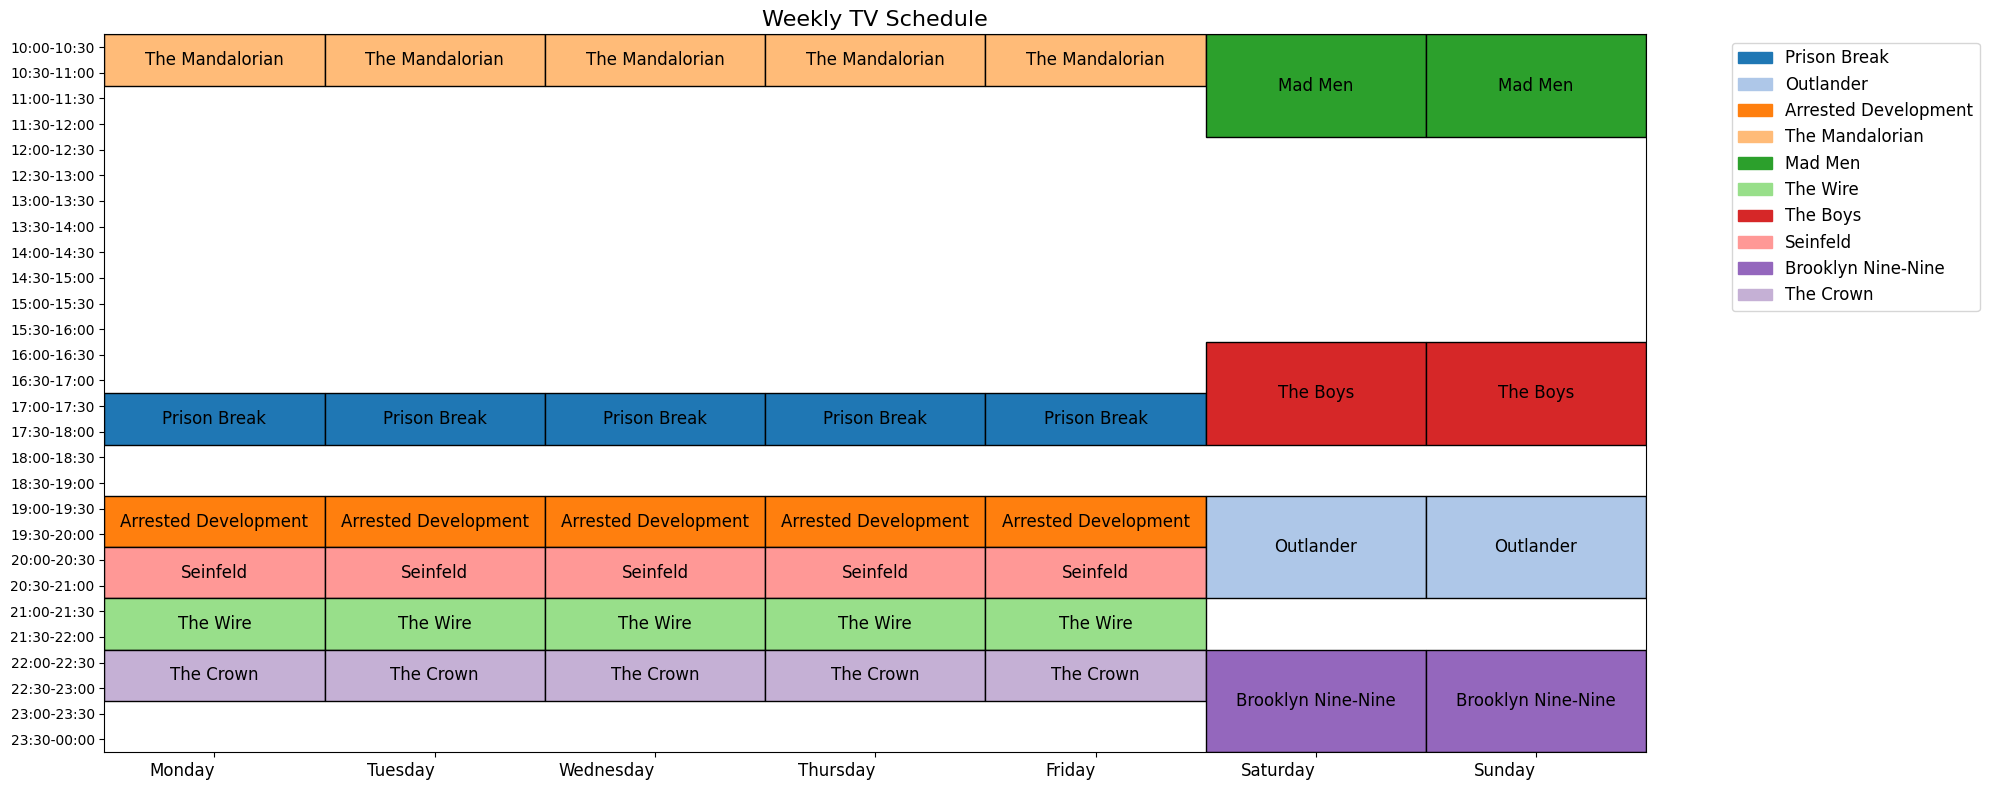

In [ ]:
# Load grid
grid = pd.read_excel("grid.xlsx", index_col=0)
TIME_LABELS = grid.index.tolist()
DAYS = grid.columns.tolist()

# Map programs to genres
try:
    sched_df = pd.read_excel("sched_df.xlsx")  # replace if available
    prog_to_genre = dict(zip(sched_df['Program'], sched_df['Genre']))
except:
    prog_to_genre = {prog: prog for col in grid.columns for prog in grid[col].unique() if pd.notna(prog)}

# Assign colors to genres
unique_genres = list(set(prog_to_genre.values()))
colors = plt.cm.tab20.colors
genre_colors = {g: colors[i % len(colors)] for i, g in enumerate(unique_genres)}

# Find first and last non-empty row across all days
non_empty = grid.applymap(lambda x: pd.notna(x) and x != '')
non_empty_rows = non_empty.any(axis=1)
first_pos = grid.index.get_loc(non_empty_rows.idxmax())
last_pos = grid.index.get_loc(non_empty_rows[::-1].idxmax())

# Slice grid to only used time slots
grid_used = grid.iloc[first_pos:last_pos + 1]
TIME_LABELS_USED = grid_used.index.tolist()

# Make figure wider and taller
fig_width = 20
fig_height = max(8, len(TIME_LABELS_USED) * 0.25)  # height proportional to number of slots
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Draw grid
for day_idx, day in enumerate(DAYS):
    col = grid_used[day]
    start_idx = None
    last_prog = None
    for row_idx, prog in enumerate(col):
        if pd.isna(prog) or prog == '':
            prog = None

        if prog != last_prog:
            if last_prog is not None:
                ax.add_patch(
                    plt.Rectangle((day_idx, start_idx), 1, row_idx - start_idx,
                                  facecolor=genre_colors.get(prog_to_genre.get(last_prog,last_prog),"#CCCCCC"),
                                  edgecolor="black")
                )
                if last_prog:
                    ax.text(day_idx + 0.5, start_idx + (row_idx - start_idx)/2, last_prog,
                            ha="center", va="center", fontsize=12, wrap=True)
            start_idx = row_idx
            last_prog = prog
    # Final rectangle
    if last_prog is not None:
        ax.add_patch(
            plt.Rectangle((day_idx, start_idx), 1, len(col)-start_idx,
                          facecolor=genre_colors.get(prog_to_genre.get(last_prog,last_prog),"#CCCCCC"),
                          edgecolor="black")
        )
        if last_prog:
            ax.text(day_idx + 0.5, start_idx + (len(col)-start_idx)/2, last_prog,
                    ha="center", va="center", fontsize=12, wrap=True)

# Axes
ax.set_xlim(0, len(DAYS))
ax.set_ylim(0, len(TIME_LABELS_USED))
ax.set_xticks([i+0.5 for i in range(len(DAYS))])
ax.set_xticklabels(DAYS, rotation=0, ha="right", fontsize=12)
ax.set_yticks([i+0.5 for i in range(len(TIME_LABELS_USED))])
ax.set_yticklabels(TIME_LABELS_USED, fontsize=10)
ax.invert_yaxis()
ax.set_aspect('auto')  # allow wider rectangles

# Legend
patches = [mpatches.Patch(color=genre_colors[g], label=g) for g in unique_genres]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.title("Weekly TV Schedule", fontsize=16)
plt.tight_layout()
plt.show()

In [101]:
new_shows_df

,ProgramName,Genre,Subgenre,Tone,Violence,Themes,Age,Expected_TRP
0,Seinfeld,Comedy,1,0,0,0,12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Arrested Development,Comedy,1,3,0,5,14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Brooklyn Nine-Nine,Comedy,1,0,1,4,12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,The Crown,Drama,0,4,1,5,16,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,The Wire,Drama,0,2,3,4,17,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
5,Mad Men,Drama,0,4,1,2,16,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
6,The Mandalorian,Action,4,2,2,3,12,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
7,The Boys,Action,2,2,3,4,18,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
8,Prison Break,Action,2,2,3,3,16,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
9,Outlander,Romance,0,2,3,1,16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
